# HVAE on Brats With Loss From Li et. al 2022

This notebook makes use of the changes to the HVAE loss function demonstrated in Li et. al 2022 to help 
alleviate thep problem of posterior collapse. This gives us better reconstructions as we force more of the
latent layers to sample from the prior.

The experiments that make use of the subvolume data require the models that do not have "slice" in their name.

Some concerns + areas to explore:
  - The imbalance between the anomalous dataset and the healthy dataset is very imbalanced, so don't trust
    the AUROC scores too much for the slice results and newest subvolume results (I ended up taking the 
    training images that were not selected/had anomalies and put them into the anom dataset as well).
  - If you look at the training logs of the slice models, we can see that the performance of the model's
    plain likelihood function w.r.t AUROC, AUPRC, is good compared to L>k and LLR>k, which is counter 
    intuitive to what the literature tells us. I think this is a function of overfitting.
  - If you look at the earlier epochs (i.e from 2000 onwards) you will see that there is still a gap between
    L>k and L>0 (plain likelihood) however as training progresses this gap closes.
  - LLR is performing poorly for some reason, may have to do will poor choice of # of layers or latent dim?
    Regardless for voxel level detection we want to look at L>k
  - The distributions of residuals we are looking at may be sensitive to how many reconstruction samples we
    take the residual with
  - One approach that I see to ideas to deal with this:
        * Take n samples for each image and take the residual with the ground truth. Then we have n x (size
        of train + size of val) = # of residuals. Then for each pixel position in the image, we have that many
        number of data points to model the distribution of the residuals
  - You will notice that the reconstructions produced from the validation images have noticeably more 
  prominent residuals than the training set (again, indicative of overfit). We would likely need to
  focus our modelling of the residual distributions through these unseen during training images.
  - It may be beneficial to select checkpoints models from the earlier epochs to circumvent above (kind of like
  an early stopping) and train models that save checkpoints more often. See how validation loss begins dropping
  after the 2000th epoch (in the block where the log tests on the healthy and anom datasets, something like
  BratsLinearNormalization --> healthy and BratsLinearNormalization-1 --> anom), both for the healthy and
  the anomalous datasets.
      * This coincides from an idea from Zhang et al. 2021 where they mentioned how models that are good at
      generation does not imply model that is good at OOD detection. In this case we trained a model to overfit
      on a specific subset of healthy data, which made it worse at generalizing to newer healthy images yet
      it was also better at identifying OOD images.
      

The sections from Hierarchical Segmentations below is the most recent work, where it mainly revolves around
1) modelling the distribution of residuals for each pixel position using a half-normal distribution then
performing a threshold at some probability to flag elements as anomalous and 2) using the residual values from
each of the reconstructions as a feature in another ML model like LOF or a One-Class SVM.

In [1]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import torch
import torchvision
import numpy as np
import nibabel as nib
from typing import Set, List
from skimage import exposure

from sklearn.metrics import auc, roc_curve, average_precision_score, precision_recall_curve
from tqdm import tqdm, trange
from collections import defaultdict
from scipy.stats import multivariate_normal

import oodd
import oodd.models
import oodd.datasets
import oodd.losses
import oodd.evaluators
import oodd.utils
from oodd.layers.likelihoods import grayscale_log_continuous_mix_logistic

np.set_printoptions(suppress=True)
device = torch.device('cuda:0')

mood_brain_dir = '/data/mood/brain/brain_train'
mood_brain_mask_dir = '/data/mood/brain/toy_label/pixel'
mood_brain_toy_dir = '/data/mood/brain/toy'

mood_abdom_dir = '/data/mood/abdom/abdom_train'
mood_abdom_mask_dir = '/data/mood/abdom/toy_label/pixel'
mood_abdom_toy_dir = '/data/mood/abdom/toy'

DEFAULT_FONTSIZE = 13
sns.set_style('white')
mpl.rcParams.update({
    'font.size': DEFAULT_FONTSIZE,
    'lines.linewidth': 2,
    'legend.fontsize': DEFAULT_FONTSIZE,
    'axes.labelsize': DEFAULT_FONTSIZE,
    'xtick.labelsize': DEFAULT_FONTSIZE,
    'ytick.labelsize': DEFAULT_FONTSIZE,
    'figure.figsize': (7, 7.0 / 1.4),
})

ctx = sns.plotting_context('paper')

In [2]:
def make_strided_patches(img, patch_size=(28, 28), stride=(4, 4), tol=0.1, bg_tol=0.):
    """
    Returns a tuple of patches and coordinates given the a 2D slice of an image an optional 
    patch size and the stride length parameters.
    """
    # For our case of medical images, we discard images that are purely background
    if (img == 0).all():
        return None
    
    
    pipeline = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        oodd.datasets.transforms.PctileChauhan(0.05)
    ])

    def preprocess(arr, pipeline):
        arr = arr.astype('float32')
        return pipeline(arr)
    
    patches = []
    coords = []
    
    x_stride = stride[0]
    y_stride = stride[1]
    
    x_max = img.shape[0]
    y_max = img.shape[1]
    
    n_xstrides = (x_max - patch_size[0]) // x_stride
    n_ystrides = (y_max - patch_size[1]) // y_stride
    for x_stride_num in range(n_xstrides + 1):
        x_cur = x_stride_num * x_stride
        for y_stride_num in range(n_ystrides + 1):
            y_cur = y_stride_num * y_stride
            y2 = y_cur + patch_size[1]
            
            x2 = x_cur + patch_size[0]
            patch = img[x_cur : x2, y_cur: y2]
            if (patch <= bg_tol).sum() <= int(patch_size[0] * patch_size[0] * tol):
                patches.append(preprocess(patch, pipeline))
                coords.append([x_cur, x2, y_cur, y2])
            
    if not patches:
        return None
    
    patches = torch.cat(patches).view(-1, 1, patch_size[0], patch_size[1])
    coords = torch.tensor(coords)
    return patches, coords

def get_nifti(dirname: str, key_words: Set[str] = {}) -> List[str]:
    """
    Return a list of relative file paths to nifti images from the passed
    directory.

    dirname can be relative or absolute.
    """
    walk = os.walk(dirname)
    img_paths = []
    valid_file_types = {'.nii', '.nii.gz'}

    for root, dirs, files in walk:
        for f in files:
            has_kw = all(key_word in f for key_word in key_words)
            
            if (f.endswith('.nii') or f.endswith('.nii.gz')) and has_kw:
                img_paths.append(os.path.join(root, f))
                
    return img_paths

def train_test_split_filenames(dir_or_arr, num_img=None, test_size=0, seed=None, shuffle=True):
    """Creating a train/test split for the file paths of each image"""
    if isinstance(dir_or_arr, str):
        filenames = [os.path.join(dir_or_arr, fn) for fn in os.scandir(dir_or_arr)]
    else:
        filenames = dir_or_arr
    
    if not num_img:
        num_img = len(filenames)
        
    if isinstance(test_size, float):
        train_size = num_img - np.ceil(num_img * test_size).astype(int)
    elif isinstance(test_size, int):
        train_size = num_img - test_size
    else:
        raise TypeError
    
    if shuffle:
        rng = np.random.default_rng(seed=seed)
        rng.shuffle(filenames)
        
    train_paths = filenames[:train_size]
    test_paths = filenames[train_size: num_img]
    
    return train_paths, test_paths

def image_generator(img_paths, tol=0):
    """Loads numpy arrays of images from disk"""
    for path in img_paths:
        img = nib.load(path)
        img_data = img.get_fdata()
        yield img_data, tol
        
def dice(predicted, ground_truth):
    tp = np.sum(predicted & ground_truth)
    fp = np.sum(predicted & (ground_truth != 1))
    fn = np.sum((predicted == 0) & ground_truth)
    dice = 2*tp/(2*tp + fp + fn)
    return dice

In [3]:
"""
9000
9100
9300
"""
#checkpoint_axial = oodd.models.Checkpoint(path='models/brats_reg_norm_half_dc_10000')
#checkpoint_axial = oodd.models.Checkpoint(path='models/brats_reg_norm_half_dc_10000_4_latent')
#checkpoint_axial = oodd.models.Checkpoint(path='./models/BratsSubvolumeLinearNormalization-VAE-dc-2023-05-19-21-16-14.148260')
#checkpoint_axial = oodd.models.Checkpoint(path='./models/BratsSubvolumeLinearNormalization-VAE-dc-2023-05-21-00-22-30.066301')
#checkpoint_axial = oodd.models.Checkpoint(path='models/brats_reg_norm_half_slice_dc_4000_rawimg')
checkpoint_axial = oodd.models.Checkpoint(path='models/brats_reg_norm_half_slice_dc_4000_rawimg_fixed')

checkpoint_axial.path
checkpoint_axial.load_model()

model_axial = checkpoint_axial.model
model_axial.eval()
model_axial.to(device)

#models = {'axial': model_axial, 'sagittal': model_sagittal, 'coronal': model_coronal}
models = {'axial': model_axial}
#models_abdom = {'axial': model_abdom}
#criterion = oodd.losses.ELBO()

In [4]:
dirname = '/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/'
brats_2018_paths = get_nifti(dirname, key_words={'flair'})
brats_2018_seg_paths = get_nifti(dirname, key_words={'seg'})

train_fn, val_fn = train_test_split_filenames(
    brats_2018_paths, test_size=0.1, shuffle=True, seed=11)
seg_train_fn, seg_val_fn = train_test_split_filenames(
    brats_2018_seg_paths, test_size=0.1, shuffle=True, seed=11)

In [5]:
brats_val_imgs = image_generator(val_fn)
brats_val_segs = image_generator(seg_val_fn)

In [154]:
brats_img, _ = next(brats_val_imgs)
brats_seg, _ = next(brats_val_segs)

In [155]:
brats_img1, _ = next(brats_val_imgs)
brats_seg1, _ = next(brats_val_segs)

In [156]:
brats_img2, _ = next(brats_val_imgs)
brats_seg2, _ = next(brats_val_segs)

(array([ 12848.,  39422.,  49580.,  52410.,  75784., 179005., 317358.,
        298459., 183313.,  81041.,  37268.,  21198.,  13448.,   9274.,
          6868.,   5003.,   3941.,   3214.,   2475.,   2078.,   1893.,
          1556.,   1389.,   1295.,   1058.,    961.,    933.,    695.,
           688.,    614.,    498.,    473.,    427.,    343.,    277.,
           227.,    163.,    135.,    136.,     77.,     57.,     38.,
            24.,     12.,     11.,      6.,      4.,      5.,      0.,
             1.]),
 array([   1.  ,   27.34,   53.68,   80.02,  106.36,  132.7 ,  159.04,
         185.38,  211.72,  238.06,  264.4 ,  290.74,  317.08,  343.42,
         369.76,  396.1 ,  422.44,  448.78,  475.12,  501.46,  527.8 ,
         554.14,  580.48,  606.82,  633.16,  659.5 ,  685.84,  712.18,
         738.52,  764.86,  791.2 ,  817.54,  843.88,  870.22,  896.56,
         922.9 ,  949.24,  975.58, 1001.92, 1028.26, 1054.6 , 1080.94,
        1107.28, 1133.62, 1159.96, 1186.3 , 1212.64, 1238.

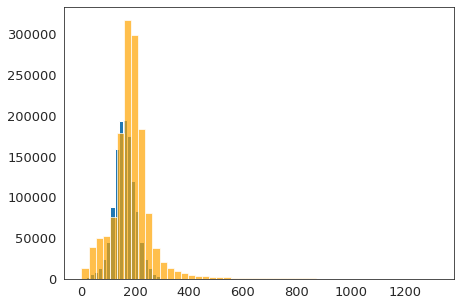

In [345]:
plt.hist(brats_img1.ravel()[(brats_img1.ravel() > 0) & (brats_seg1.ravel() == 0)], bins=50)
plt.hist(brats_img2.ravel()[(brats_img2.ravel() > 0) & (brats_seg2.ravel() == 0)], color='orange', alpha=0.7, bins=50)

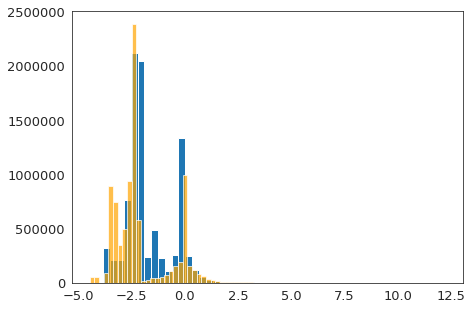

In [10]:
mx_1 = brats_img1.max(axis=(0, 1))
mask_1 = np.ma.masked_array(brats_img1, mask=brats_img1 == 0)
mu_1 = mask_1.mean(axis=(0, 1))
stdev_1 = mask_1.std(axis=(0, 1))
#scaled_img1 = brats_img1 / np.where(mx_1 == 0, 1, mx_1)
scaled_img1 = (brats_img1 - mu_1) / stdev_1

mx_2 = brats_img2.max(axis=(0, 1))
mask_2 = np.ma.masked_array(brats_img2, mask=brats_img2 == 0)
mu_2 = mask_2.mean(axis=(0, 1))
stdev_2 = mask_2.std(axis=(0, 1))

#scaled_img2 = brats_img2 / np.where(mx_2 == 0, 1, mx_2)
scaled_img2 = (brats_img2 - mu_2) / stdev_2

h = plt.hist(scaled_img1.ravel()[(scaled_img1.ravel() > -20) & (brats_seg1.ravel() == 0)], bins=50)
h = plt.hist(scaled_img2.ravel()[(scaled_img2.ravel() > -20) & (brats_seg1.ravel() == 0)], color='orange', alpha=0.7, bins=50)

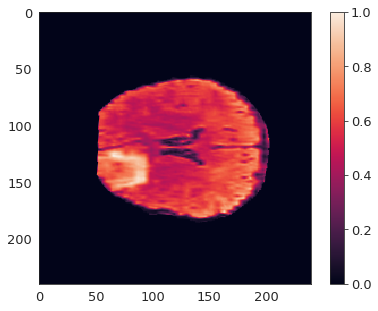

In [265]:
brats_slice = brats_img1[:, :, 89]

brats_slice = (brats_slice / brats_slice.max())
plt.imshow(brats_slice)
plt.colorbar()

In [65]:
np.ma.masked_array(brats_slice, mask=(brats_slice == 0)).min()

0.0014925373134328358

array([0., 1., 2., 4.])

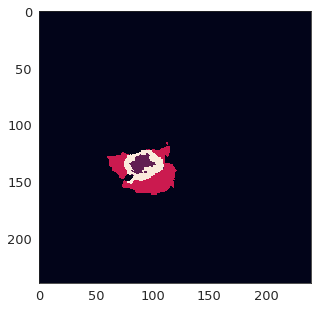

In [13]:
brats_slice_seg = brats_seg[:, :, 89]
plt.imshow(brats_slice_seg)
np.unique(brats_slice_seg)

In [14]:
brats_img, _ = next(brats_val_imgs)
brats_seg, _ = next(brats_val_segs)

### Patches Model

In [15]:
iw_samples_elbo = 1
iw_samples_Lk = 1
batch_size = 256
n_latents_skip = 2
n_eval_examples = float("inf")

brain_name = 'brats'
brain = brats_img[:, :, 89:93]


#x_inds, y_inds = np.indices((28, 28)) - 14
#weight_mask = 1 - (np.sqrt(x_inds**2 + y_inds ** 2) / 28)

#mv_norm = multivariate_normal(mean=[0, 0], cov=np.eye(2)*60)
#peak = mv_norm.pdf([0, 0])
#weight_mask = mv_norm.pdf(np.c_[x_inds.ravel(), y_inds.ravel()]).reshape(28, 28) / peak

SCORES = defaultdict(list)
COMP_SCORES = defaultdict(list)

def get_decode_from_p(n_latents, k=0, semantic_k=True):
    """
    k semantic out
    0 True     [False, False, False]
    1 True     [True, False, False]
    2 True     [True, True, False]
    0 False    [True, True, True]
    1 False    [False, True, True]
    2 False    [False, False, True]
    """
    if semantic_k:
        return [True] * k + [False] * (n_latents - k)

    return [False] * (k + 1) + [True] * (n_latents - k - 1)

def get_lengths(dataloaders):
    return [len(loader) for name, loader in dataloaders.items()]

voxel_scores = []
means = []
stride = (4, 4)
tol = 0
bg_tol = 0

for plane in models:
    model = models[plane]
    
    score_mask = np.full(brain.shape, 0., dtype='float32')
    #score_mask = np.full((512, 512, 512), 0., dtype='float32')
    #score_mask = np.full((256, 256, 256, 50), 0., dtype='float32')
    #score_mask = np.empty((256, 256, 256, 50), dtype='object')
    #for i, row in enumerate(score_mask):
    #    for j, col in enumerate(row):
    #        for z, width in enumerate(col):
    #            score_mask[i, j, z] = []
    #mean_mask = np.full((512, 512, 512), 0.)
    mean_mask = np.full(brain.shape, 0.)
    
    for z in trange(brain.shape[-1]):
        if plane == 'axial':
            strided_patches = make_strided_patches(brain[:, :, z], stride=stride, tol=tol, bg_tol=bg_tol)
        elif plane == 'sagittal':
            strided_patches = make_strided_patches(brain[z, :, :], stride=stride, tol=tol, bg_tol=bg_tol)
        elif plane == 'coronal':
            strided_patches = make_strided_patches(brain[:, z, :], stride=stride, tol=tol, bg_tol=bg_tol)
        if strided_patches:
            stride_gen, coords = strided_patches 
        else:
            continue
        dataset = torch.utils.data.TensorDataset(stride_gen, coords)
        loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

        #n_test_batches = get_lengths(datamodule.val_datasets) + get_lengths(datamodule.test_datasets)
        #N_EQUAL_EXAMPLES_CAP = min(n_test_batches)
        #assert N_EQUAL_EXAMPLES_CAP % batch_size == 0, "Batch size must divide smallest dataset size"
        #N_EQUAL_EXAMPLES_CAP = min([n_eval_examples, N_EQUAL_EXAMPLES_CAP])

        decode_from_p = get_decode_from_p(model.n_latents, k=n_latents_skip)
        comp_decode_from_p = get_decode_from_p(model.n_latents, k=1, semantic_k=False)

        scores = defaultdict(list)
        elbos = defaultdict(list)
        elbos_k = defaultdict(list)
        elbos_l = defaultdict(list)
        gen_llr_scores = defaultdict(list)
        with torch.no_grad():
            n = 0
            for b, (x, coord) in enumerate(loader):
                x = x.to(device)
                n += x.shape[0]
                sample_elbos, sample_elbos_k, sample_elbos_l = [], [], []

                # Regular ELBO
                for i in range(iw_samples_elbo):
                    likelihood_data, stage_datas = model(x, decode_from_p=False, use_mode=False)
                    kl_divergences = [
                        stage_data.loss.kl_elementwise
                        for stage_data in stage_datas
                        if stage_data.loss.kl_elementwise is not None
                    ]
                    loss, elbo, likelihood, kl_divergences = criterion(
                        likelihood_data.likelihood,
                        kl_divergences,
                        samples=1,
                        free_nats=0,
                        beta=1,
                        sample_reduction=None,
                        batch_reduction=None,
                    )
                    sample_elbos.append(elbo.detach())

                # L>k bound
                for i in range(iw_samples_Lk):
                    likelihood_data_k, stage_datas_k = model(x, decode_from_p=decode_from_p, use_mode=decode_from_p)
                    kl_divergences_k = [
                        stage_data.loss.kl_elementwise
                        for stage_data in stage_datas_k
                        if stage_data.loss.kl_elementwise is not None
                    ]
                    loss_k, elbo_k, likelihood_k, kl_divergences_k = criterion(
                        likelihood_data_k.likelihood,
                        kl_divergences_k,
                        samples=1,
                        free_nats=0,
                        beta=1,
                        sample_reduction=None,
                        batch_reduction=None,
                    )
                    sample_elbos_k.append(elbo_k.detach())
                    
                # L>l bound
                for i in range(iw_samples_Lk):
                    likelihood_data_l, stage_datas_l = model(x, decode_from_p=comp_decode_from_p, use_mode=comp_decode_from_p)
                    kl_divergences_l = [
                        stage_data.loss.kl_elementwise
                        for stage_data in stage_datas_l
                        if stage_data.loss.kl_elementwise is not None
                    ]
                    loss_l, elbo_l, likelihood_l, kl_divergences_l = criterion(
                        likelihood_data_l.likelihood,
                        kl_divergences_l,
                        samples=1,
                        free_nats=0,
                        beta=1,
                        sample_reduction=None,
                        batch_reduction=None,
                    )
                    sample_elbos_l.append(elbo_k.detach())

                sample_elbos = torch.stack(sample_elbos, axis=0)
                sample_elbos_k = torch.stack(sample_elbos_k, axis=0)
                sample_elbos_l = torch.stack(sample_elbos_l, axis=0)

                sample_elbo = oodd.utils.log_sum_exp(sample_elbos, axis=0)
                sample_elbo_k = oodd.utils.log_sum_exp(sample_elbos_k, axis=0)
                sample_elbo_l = oodd.utils.log_sum_exp(sample_elbos_l, axis=0)

                score = sample_elbo - sample_elbo_k
                gen_llr_score = sample_elbo_l - sample_elbo_k

                for ind, (x1, x2, y1, y2) in enumerate(coord):
                    if plane == 'axial':
                        score_mask[x1:x2, y1:y2, z] += score[ind].detach().cpu().numpy()
                        mean_mask[x1:x2, y1:y2, z] += 1
                    elif plane == 'sagittal':
                        score_mask[z, x1:x2, y1:y2] += score[ind].detach().cpu().numpy()
                        mean_mask[z, x1:x2, y1:y2] += 1
                    elif plane == 'coronal':
                        score_mask[x1:x2, z, y1:y2] += score[ind].detach().cpu().numpy()
                        mean_mask[x1:x2, z, y1:y2] += 1

                    #score_mask[x1:x2, y1:y2] += weight_mask * score[ind].detach().cpu().numpy()
                    #mean_mask[x1:x2, y1:y2] += weight_mask

                    #patch_score = score[ind].detach().cpu().numpy()
                    #score_slice = score_mask[x1:x2, y1:y2, z]

                    #for row in pixel_lists:
                    #    for col in row:
                    #        col.append(patch_score)
                    #score_slice[np.nonzero(pixel_lists)] = patch_score
                    #score_slice[:, :, np.argmax(score_slice == 0, axis=-1)] = patch_score

                scores[brain_name].extend(score.tolist())
                elbos[brain_name].extend(sample_elbo.tolist())
                elbos_k[brain_name].extend(sample_elbo_k.tolist())
                elbos_l[brain_name].extend(sample_elbo_l.tolist())
                gen_llr_scores[brain_name].extend(gen_llr_score.tolist())

        SCORES[brain_name].extend(scores[brain_name])
        COMP_SCORES[brain_name].extend(gen_llr_scores[brain_name])
    means.append(mean_mask)
    voxel_scores.append(score_mask)

  0%|          | 0/4 [00:00<?, ?it/s]


RuntimeError: Given groups=1, weight of size [64, 4, 5, 5], expected input[256, 1, 28, 28] to have 4 channels, but got 1 channels instead

<ipython-input-192-215c7e9b75c9>:1: RuntimeWarning: invalid value encountered in divide
  per_pixel_map_axial = voxel_scores[0] / means[0]


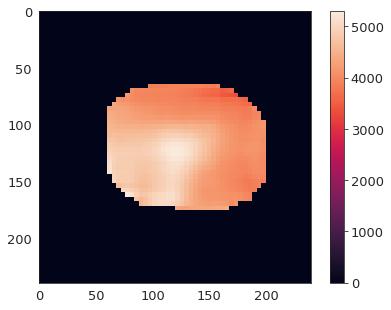

In [192]:
per_pixel_map_axial = voxel_scores[0] / means[0]
per_pixel_map_axial = np.where(np.isnan(per_pixel_map_axial), 0, per_pixel_map_axial)
#plt.imshow(per_pixel_map_axial[:, :, 89])
plt.imshow(per_pixel_map_axial[:, :, 2])
plt.colorbar()

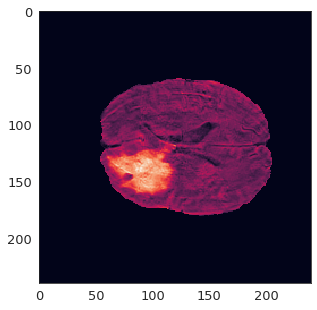

In [193]:
plt.imshow(brats_img[:, :, 89])

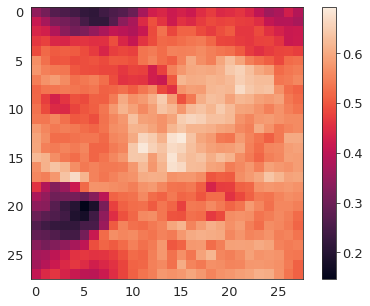

In [233]:
anom_patch = brats_img[125:125+28, 75:75+28, 89]
plt.imshow(anom_patch)

with torch.no_grad():
    inp = torch.tensor(anom_patch.astype('float32'), device=device).unsqueeze(0).unsqueeze(0)
    ll, stage = models['axial'](inp, decode_from_p=[True, True, False])
plt.colorbar()

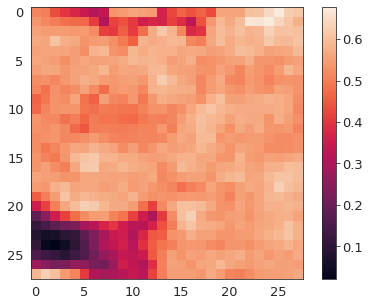

In [234]:
plt.imshow(ll.mean.cpu().squeeze())
plt.colorbar()

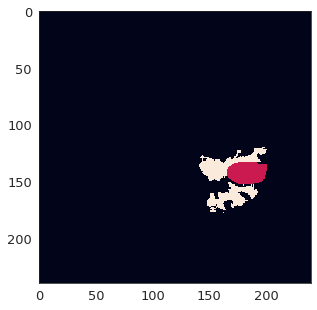

In [333]:
plt.imshow(brats_seg[:, :, 90])

In [334]:
plt.hist(per_pixel_map_axial[:, :, 78].ravel()[(per_pixel_map_axial[:, :, 78] > 6650).ravel()])

IndexError: index 78 is out of bounds for axis 2 with size 4

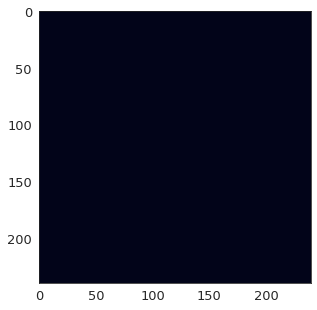

In [335]:
#plt.imshow((per_pixel_map_axial[:, :, 0] > 6000) & (brats_seg[:, :, 89] != 0))
plt.imshow((per_pixel_map_axial[:, :, 0] > 7250))

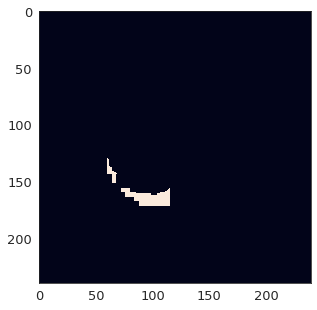

In [268]:
plt.imshow((per_pixel_map_axial[:, :, 0] > 6600) & (brats_seg[:, :, 89] == 0))

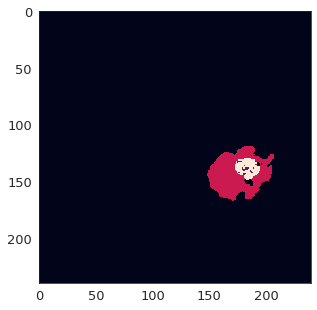

In [287]:
plt.imshow(brats_seg[:, :, 89])

(array([368., 160., 288., 192., 336., 448., 944., 528., 400., 176.]),
 array([6101.40178571, 6172.71922433, 6244.03666295, 6315.35410156,
        6386.67154018, 6457.98897879, 6529.30641741, 6600.62385603,
        6671.94129464, 6743.25873326, 6814.57617188]),
 <a list of 10 Patch objects>)

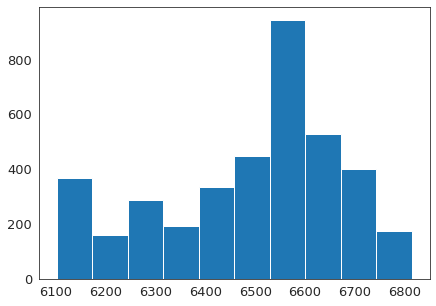

In [77]:
plt.hist(per_pixel_map_axial[:, :, 89].ravel()[(per_pixel_map_axial[:, :, 89] > 6100).ravel()])

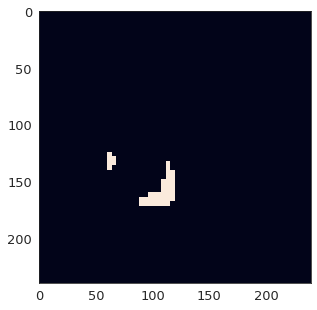

In [29]:
plt.imshow(per_pixel_map_axial[:, :, 0]> 6000)

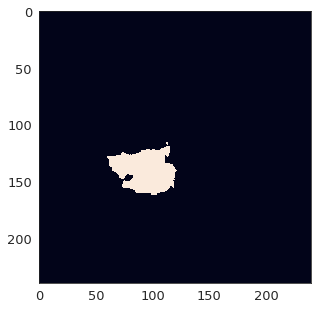

In [16]:
plt.imshow(brats_seg[:, :, 89] != 0)

In [352]:
predicted = per_pixel_map_axial
bool_preds = np.full(predicted.shape, False)
ground = (brats_seg[:, :, 89:93] != 0)


for sl in range(predicted.shape[-1]):
    pred_slice = predicted[:, :, sl]
    gt_slice = ground[:, :, sl]
    freq, bins = np.histogram(pred_slice.ravel()[pred_slice.ravel() > 6200], bins=5)
    if not (freq == 0).all():
        max_bin = bins[np.argmax(freq)]
        thresholded_slice = pred_slice > max_bin
        print(sl, dice(thresholded_slice, ground[:, :, sl]))
        bool_preds[:, :, sl] = thresholded_slice

0 0.7574269005847953
1 0.7815715622076708
2 0.7613753345686638
3 0.6792156862745098


In [251]:
for sl in range(predicted.shape[-1]):
    pred_slice = predicted[:, :, sl]
    gt_slice = ground[:, :, sl]
    print(sl, dice(pred_slice > 6250, ground[:, :, sl]))

0 0.38070175438596493
1 0.33935018050541516
2 0.2887128712871287
3 0.30367667695761996


In [353]:
dice(bool_preds, ground)

0.742489734169008

In [117]:
brats_seg.shape

(240, 240, 155)

In [75]:
predicted = (per_pixel_map_axial[:, :, 89] > 6450) 
ground = (brats_slice_seg != 0)

dice(predicted, ground)
#average_precision_score(predicted.ravel(), ground.ravel())

0.7621052631578947

In [55]:
average_precision_score(bool_preds.ravel(), ground.ravel())

0.4153438918325161

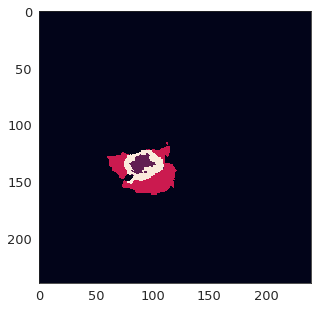

In [33]:
plt.imshow(brats_slice_seg)

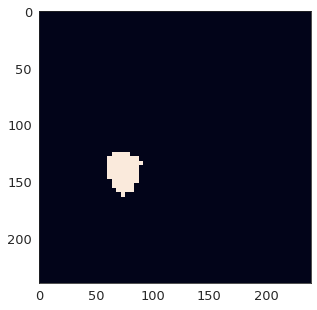

In [53]:
plt.imshow(per_pixel_map_axial[:, :, 78] > 6300)

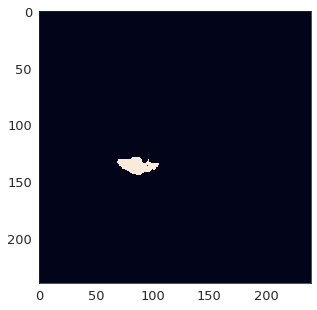

In [243]:
plt.imshow(brats_seg[:, :, 78])

### Brats Full Subvolumes

In [21]:
dirname = '/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/'
brats_2018_paths = get_nifti(dirname, key_words={'flair'})
brats_2018_seg_paths = get_nifti(dirname, key_words={'seg'})

model = model_axial

train_fn, val_fn = train_test_split_filenames(
    brats_2018_paths, test_size=0.1, shuffle=True, seed=11)
seg_train_fn, seg_val_fn = train_test_split_filenames(
    brats_2018_seg_paths, test_size=0.1, shuffle=True, seed=11)

In [22]:
brats_val_imgs = image_generator(val_fn)
brats_val_segs = image_generator(seg_val_fn)

brats_img, _ = next(brats_val_imgs)
brats_img = brats_img / brats_img.max() # hacky normalization
brats_seg, _ = next(brats_val_segs)

In [23]:
# Computing the reconstructions of validation subvolumes
recons = []
with torch.no_grad():
    for _ in range(16):
        center_crop = torchvision.transforms.CenterCrop((224, 224))
        x = torch.tensor(brats_img[:, :, 89:93].astype('float32'), device=device).permute(2, 0, 1)
        x = center_crop(x).unsqueeze(0)
        ll, stage = model(x, decode_from_p=[False, False, False, False])
        recons.append(ll.mean.cpu().permute(0, 2, 3, 1))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x200704 and 100352x8)

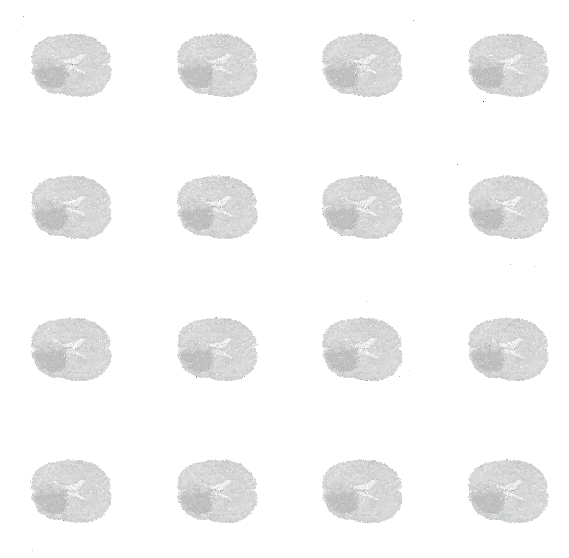

In [18]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for i, ax in enumerate(axes.ravel()):
    ax.imshow(recons[i].squeeze())
    ax.axis('off')

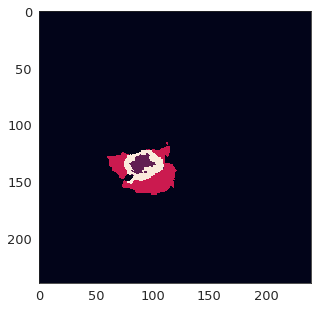

In [19]:
plt.imshow(brats_seg[:, :, 89])

In [20]:
with torch.no_grad():
    center_crop = torchvision.transforms.CenterCrop((224, 224))
    x = torch.tensor(brats_img[:, :, 89:93].astype('float32'), device=device).permute(2, 0, 1)
    x = center_crop(x).unsqueeze(0)
    ll, stage = model(x)
print(ll.likelihood)

tensor([927342.8750], device='cuda:1')


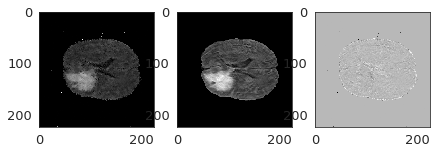

In [21]:
fig, ax = plt.subplots(1, 3)
recon = ll.mean.cpu().squeeze().permute(1, 2, 0)
ground = x.cpu().squeeze().permute(1, 2, 0)

im1 = ax[0].imshow(recon[:, :, 0], cmap='gray')
im2 = ax[1].imshow(ground[:, :, 0], cmap='gray')
im3 = ax[2].imshow(ground[:, :, 0] - recon[:, :, 0], cmap='gray')

#plt.colorbar(im1, ax=ax[0])
#plt.colorbar(im2, ax=ax[1])
#plt.colorbar(im3, ax=ax[2])

In [22]:
recons = []
with torch.no_grad():
    for _ in range(1000):
        center_crop = torchvision.transforms.CenterCrop((224, 224))
        x = torch.tensor(brats_img[:, :, 89:93].astype('float32'), device=device).permute(2, 0, 1)
        x = center_crop(x).unsqueeze(0)
        ll, stage = model(x, decode_from_p=[True, False, False, False])
        recons.append(ll.mean.cpu().permute(0, 2, 3, 1))

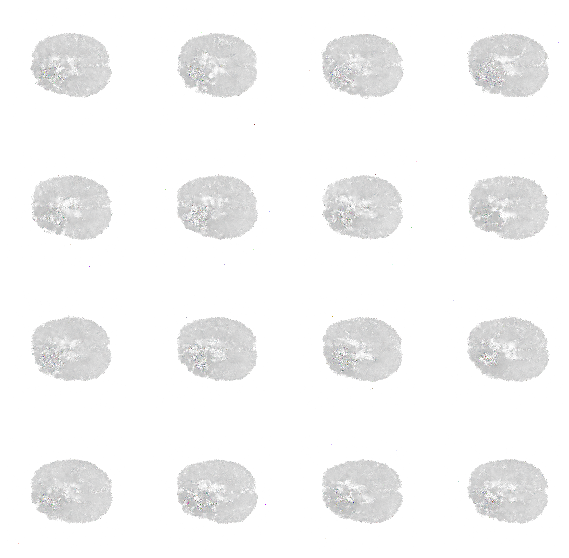

In [23]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for i, ax in enumerate(axes.ravel()):
    ax.imshow(recons[i].squeeze())
    ax.axis('off')

In [24]:
recons = []
with torch.no_grad():
    for _ in range(16):
        center_crop = torchvision.transforms.CenterCrop((224, 224))
        x = torch.tensor(brats_img[:, :, 89:93].astype('float32'), device=device).permute(2, 0, 1)
        x = center_crop(x).unsqueeze(0)
        ll, stage = model(x, decode_from_p=[False, True, False, False])
        recons.append(ll.mean.cpu().permute(0, 2, 3, 1))

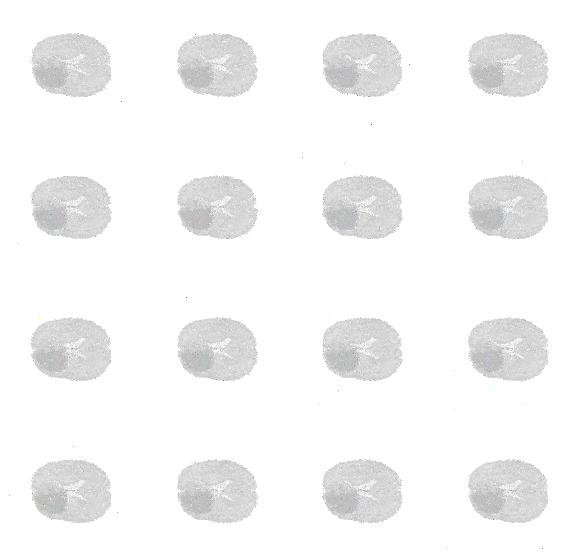

In [25]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for i, ax in enumerate(axes.ravel()):
    ax.imshow(recons[i].squeeze())
    ax.axis('off')

In [26]:
ll.likelihood

tensor([927217.5000], device='cuda:1')

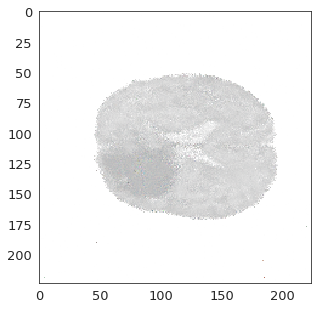

In [27]:
plt.imshow(ll.mean.cpu().squeeze().permute(1, 2, 0))

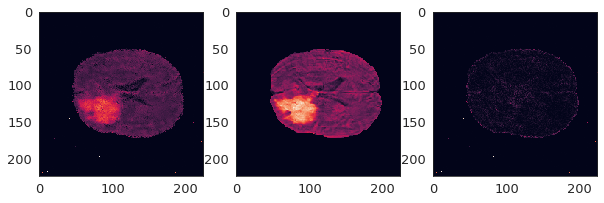

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
recon = ll.mean.cpu().squeeze().permute(1, 2, 0)
ground = x.cpu().squeeze().permute(1, 2, 0)

im1 = ax[0].imshow(recon[:, :, 0])
im2 = ax[1].imshow(ground[:, :, 0])
im3 = ax[2].imshow(np.abs(ground[:, :, 0] - recon[:, :, 0]))

#plt.colorbar(im1, ax=ax[0])
#plt.colorbar(im2, ax=ax[1])
#plt.colorbar(im3, ax=ax[2])

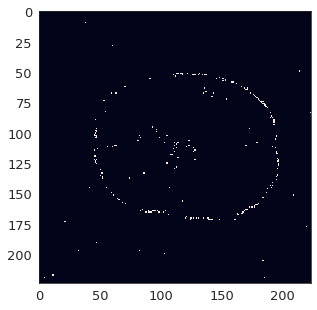

In [29]:
plt.imshow(np.abs(ground[:, :, 0] - recon[:, :, 0]) > 0.2)
#plt.colorbar()

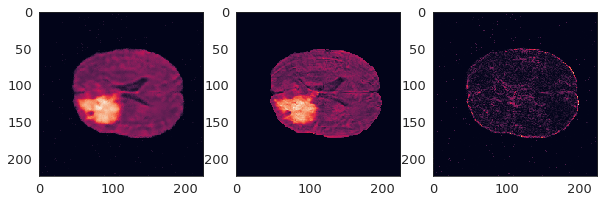

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
recon = torch.concatenate(recons, 0).mean(axis=0)
ground = x.cpu().squeeze().permute(1, 2, 0)

im1 = ax[0].imshow(recon[:, :, 0])
im2 = ax[1].imshow(ground[:, :, 0])
im3 = ax[2].imshow(np.abs(ground[:, :, 0] - recon[:, :, 0]))

#plt.colorbar(im1, ax=ax[0])
#plt.colorbar(im2, ax=ax[1])
#plt.colorbar(im3, ax=ax[2])

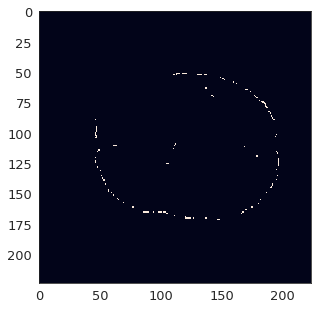

In [31]:
plt.imshow(np.abs(ground[:, :, 0] - recon[:, :, 0]) > 0.15)

### Displaying Multiple Reconstructions of z>i Of Different Images For Full Subvolumes

In [74]:
# Will need to load the 
recons_by_latents = []
brats_val_imgs = image_generator(val_fn)
brats_val_segs = image_generator(seg_val_fn)

# brats_seg, _ = next(brats_val_segs)

with torch.no_grad():
    for _ in range(4):
        brats_img, _ = next(brats_val_imgs)
        brats_img = brats_img / brats_img.max() # hacky normalization
        x = torch.tensor(brats_img[:, :, 89:93].astype('float32'), device=device).permute(2, 0, 1)
        x = center_crop(x).unsqueeze(0)
        recons_by_latents.append(x.cpu().permute(0, 2, 3, 1).numpy())
        
        for i in range(5):
            center_crop = torchvision.transforms.CenterCrop((224, 224))
            ll, stage = model(x, decode_from_p=([True] * i) + ([False] * (4 - i)))
            recons_by_latents.append(ll.mean.cpu().permute(0, 2, 3, 1).numpy())

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x200704 and 100352x8)

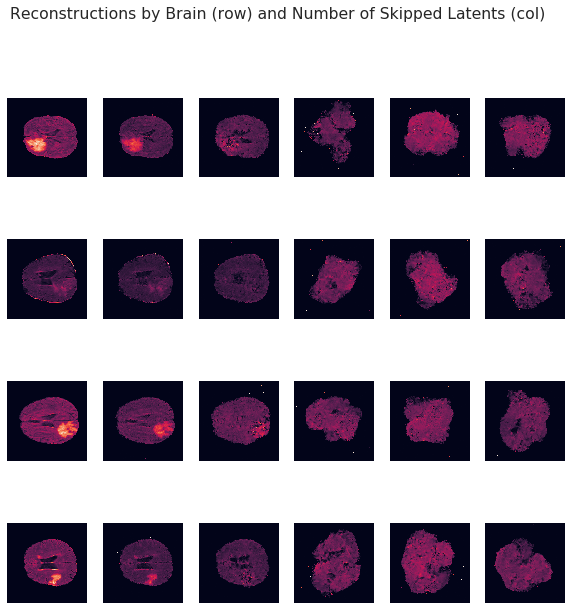

In [72]:
fig, axes = plt.subplots(4, 6, figsize=(10, 10))

for i, ax in enumerate(axes.ravel()):
    ax.imshow(recons_by_latents[i][0, :, :, 0])
    ax.axis('off')
    
s = fig.suptitle("Reconstructions by Brain (row) and Number of Skipped Latents (col)")

In [68]:
recons_by_latents[0].shape

(1, 224, 224, 4)

### Brats Half Subvolume

In [10]:
dirname = '/data/BraTS2018/BraTS18_Training_norm/'
seg_dirname = '/data/BraTS2018/BraTS18_Training_norm/'
brats_2018_paths = sorted(get_nifti(dirname, key_words={'flair_Warped'}))
brats_2018_seg_paths = sorted(get_nifti(seg_dirname, key_words={'seg'}), key=lambda f: f.split('/')[-1])

random.seed(11)
path_pairs = list(zip(brats_2018_paths, brats_2018_seg_paths))
segs = [seg for _, seg in path_pairs]
imgs = [train for train, _ in path_pairs]

train_size = int(len(imgs) - np.ceil(0.1 * len(imgs)))

train_fn = imgs[:train_size]
seg_train_fn = segs[:train_size]
val_fn = imgs[train_size:]
seg_val_fn = segs[train_size:]

In [11]:
brats_val_imgs = image_generator(val_fn)
brats_val_segs = image_generator(seg_val_fn)

In [13]:
brats_img, _ = next(brats_val_imgs)
brats_img = brats_img / brats_img.max()
brats_seg, _ = next(brats_val_segs)

In [26]:
recons = []
model = models['axial']

center_crop = torchvision.transforms.CenterCrop((224, 224))
#subvolume = central_crop(torch.tensor(np.expand_dims(subvolume[:, :, s], 0))).permute(1, 2, 0)
x = torch.tensor(brats_img[:, :, 89:93].astype('float32'), device=device).permute(2, 0, 1)
x = center_crop(x).unsqueeze(0)
        
with torch.no_grad():
    for _ in range(100):
        x_top = x[:, :, :224//2, :]
        x_bot = x[:, :, 224//2:, :]
        ll_top, stage_top, _ = model(x_top, decode_from_p=[True, True, True, False])
        ll_bot, stage_bot, _ = model(x_bot, decode_from_p=[True, True, True, False])
        
        recons.append(torch.concatenate([ll_top.mean, ll_bot.mean], dim=2).cpu().permute(0, 2, 3, 1))

In [30]:
print(list(model.modules()))

[VAE(
  kwargs={
    kwargs={'input_shape': torch.Size([4, 112, 224]), 'likelihood_module': 'GrayscaleContinuousLogisticMixLikelihoodConv2d', 'config_deterministic': [[{'block': 'ResBlockConv2d', 'out_channels': 64, 'kernel_size': 5, 'stride': 1, 'weightnorm': True, 'gated': False}, {'block': 'ResBlockConv2d', 'out_channels': 64, 'kernel_size': 5, 'stride': 1, 'weightnorm': True, 'gated': False}, {'block': 'ResBlockConv2d', 'out_channels': 64, 'kernel_size': 5, 'stride': 2, 'weightnorm': True, 'gated': False}], [{'block': 'ResBlockConv2d', 'out_channels': 64, 'kernel_size': 3, 'stride': 1, 'weightnorm': True, 'gated': False}, {'block': 'ResBlockConv2d', 'out_channels': 64, 'kernel_size': 3, 'stride': 1, 'weightnorm': True, 'gated': False}, {'block': 'ResBlockConv2d', 'out_channels': 64, 'kernel_size': 3, 'stride': 2, 'weightnorm': True, 'gated': False}], [{'block': 'ResBlockConv2d', 'out_channels': 64, 'kernel_size': 3, 'stride': 1, 'weightnorm': True, 'gated': False}, {'block': 'ResBl

In [29]:
acts = []
def get_activation():
    def hook(model, inp, out):
        ll, stage = out
        print(ll, stage)
        acts.append(ll.detach())
    return hook
        
penultimate = list(model.modules())[-8]
print(penultimate)
#penultimate.register_forward_hook(get_activation())

ll_top, stage_top, _ = model(x_top)

ReLU()


In [36]:
stage_top[0].q.z.shape

torch.Size([1, 32, 56, 112])

In [25]:
"""
9000
9100
9300
"""
#checkpoint_axial = oodd.models.Checkpoint(path='models/brats_reg_norm_half_dc_10000')
checkpoint_axial = oodd.models.Checkpoint(path='models/brats_reg_norm_half_dc_10000_4_latent')
#checkpoint_axial = oodd.models.Checkpoint(path='./models/BratsSubvolumeLinearNormalization-VAE-dc-2023-05-19-21-16-14.148260')
#checkpoint_axial = oodd.models.Checkpoint(path='./models/BratsSubvolumeLinearNormalization-VAE-dc-2023-05-21-00-22-30.066301')

checkpoint_axial.path
checkpoint_axial.load_model()

model_axial = checkpoint_axial.model
model_axial.eval()
model_axial.to(device)

#models = {'axial': model_axial, 'sagittal': model_sagittal, 'coronal': model_coronal}
models = {'axial': model_axial}
#models_abdom = {'axial': model_abdom}
#criterion = oodd.losses.ELBO()

In [16]:
acts

[tensor([425355.4375], device='cuda:1')]

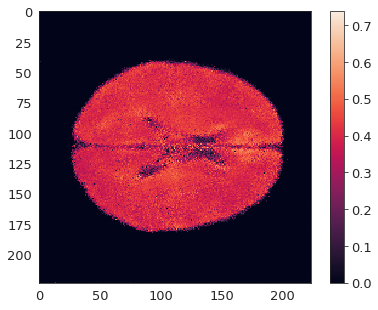

In [11]:
plt.imshow(recons[1].squeeze().cpu()[:, :, 0])
plt.colorbar()

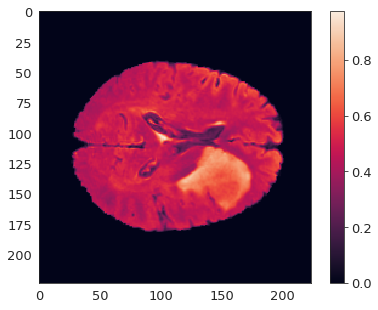

In [216]:
plt.imshow(x[:, 2, :, :].cpu().squeeze())
plt.colorbar()

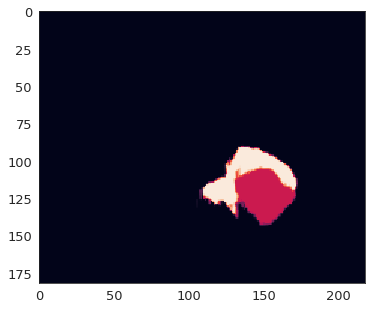

In [217]:
plt.imshow(brats_seg[:, :, 91])

tensor(1758.5520)


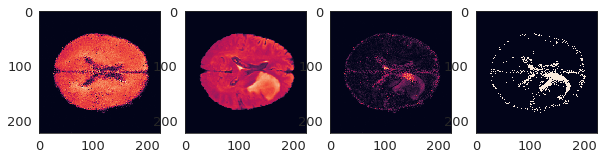

In [218]:
fig, ax = plt.subplots(1, 4, figsize=(10, 10))
#recon = torch.concatenate(recons, 0).mean(axis=0)
recon = recons[0].squeeze()
ground = x.cpu().squeeze().permute(1, 2, 0)

im1 = ax[0].imshow(recon[:, :, 2])
im2 = ax[1].imshow(ground[:, :, 2])
residual = np.abs(ground[:, :, 2] - recon[:, :, 2])
im3 = ax[2].imshow(residual)
im4 = ax[3].imshow(residual > np.percentile(residual, 95))
print(residual.sum())

#plt.colorbar(im1, ax=ax[0])
#plt.colorbar(im2, ax=ax[1])
#plt.colorbar(im3, ax=ax[2])

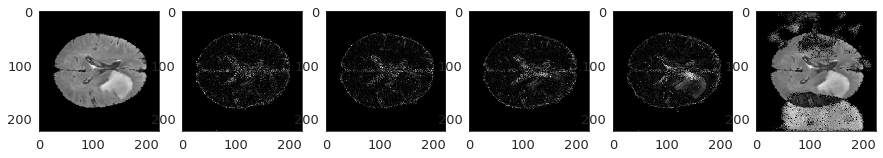

In [219]:
# Measuring the deltas across different stages
recons_by_stage = []
with torch.no_grad():
    for i in range(5):
        x_top = x[:, :, :224//2, :]
        x_bot = x[:, :, 224//2:, :]
        ll_top, stage_top, _ = model(x_top, decode_from_p=(([True] * i) + ([False] * (4 - i))))
        ll_bot, stage_bot, _ = model(x_bot, decode_from_p=(([True] * i) + ([False] * (4 - i))))
        
        recons_by_stage.append(torch.concatenate([ll_top.mean, ll_bot.mean], dim=2).cpu().permute(0, 2, 3, 1))
        
ground = x.cpu().squeeze().permute(1, 2, 0)
fig, axes = plt.subplots(1, 6, figsize=(15, 15))
axes[0].imshow(ground[:, :, 2], cmap='gray')
for rec, ax in zip(recons_by_stage, axes[1:]):
    rec = rec.squeeze()
    ax.imshow(np.abs(ground[:, :, 2] - rec[:, :, 2]), cmap='gray')

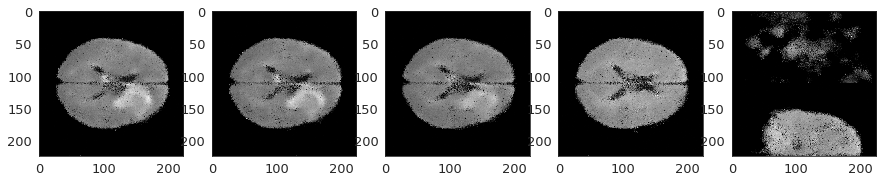

In [221]:
fig, axes = plt.subplots(1, 5, figsize=(15, 15))
for rec, ax in zip(recons_by_stage, axes):
    rec = rec.squeeze()
    ax.imshow(rec[:, :, 2], cmap='gray')

### Brats Half Slices

In [7]:
dirname = '/data/BraTS2018/BraTS18_Training_norm/'
seg_dirname = '/data/BraTS2018/BraTS18_Training_norm/'
brats_2018_paths = sorted(get_nifti(dirname, key_words={'flair_Warped'}))
brats_2018_seg_paths = sorted(get_nifti(seg_dirname, key_words={'seg'}), key=lambda f: f.split('/')[-1])

random.seed(11)
path_pairs = list(zip(brats_2018_paths, brats_2018_seg_paths))
segs = [seg for _, seg in path_pairs]
imgs = [train for train, _ in path_pairs]

train_size = int(len(imgs) - np.ceil(0.1 * len(imgs)))

train_fn = imgs[:train_size]
seg_train_fn = segs[:train_size]
val_fn = imgs[train_size:]
seg_val_fn = segs[train_size:]

In [11]:
brats_val_imgs = image_generator(val_fn)
brats_val_segs = image_generator(seg_val_fn)

In [10]:
brats_img, _ = next(brats_val_imgs)
#brats_img = np.clip(brats_img / 2, 0., 1.)
#brats_img = brats_img / 2
brats_seg, _ = next(brats_val_segs)

In [12]:
recons = []
model = models['axial']

center_crop = torchvision.transforms.CenterCrop((224, 224))
#subvolume = central_crop(torch.tensor(np.expand_dims(subvolume[:, :, s], 0))).permute(1, 2, 0)
x = torch.tensor(brats_img[:, :, [90]].astype('float32'), device=device).permute(2, 0, 1)
x = center_crop(x).unsqueeze(0)
        
with torch.no_grad():
    for _ in range(50):
        x_top = x[:, :, :224//2, :]
        #x_bot = torch.flipud(x[:, :, 224//2:, :])
        x_bot = torch.flipud(x[:, :, 224//2:, :].squeeze().cpu()).unsqueeze(0).unsqueeze(0).to(device)
        ll_top, stage_top, _ = model(x_top, decode_from_p=[True, True, True, False])
        ll_bot, stage_bot, _ = model(x_bot, decode_from_p=[True, True, True, False])
        
        recons.append(np.concatenate([ll_top.mean.permute(0, 2, 3, 1).cpu().numpy(), ll_bot.mean.permute(0, 2, 3, 1).cpu().numpy()[:, ::-1, :, :]], axis=1))

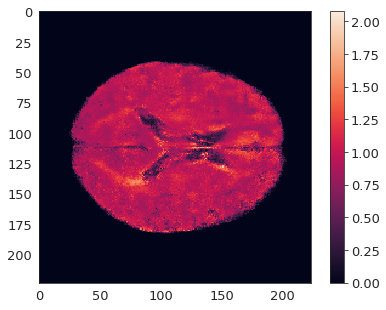

In [13]:
plt.imshow(recons[0].squeeze())
plt.colorbar()

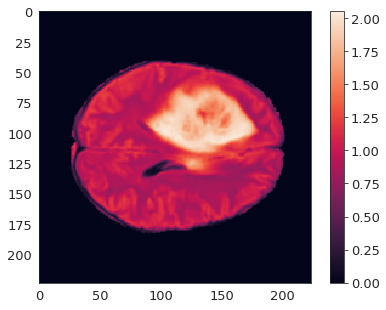

In [70]:
plt.imshow(x.squeeze().cpu())
plt.colorbar()

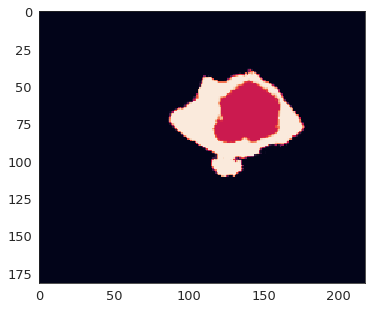

In [71]:
plt.imshow(brats_seg[:, :, 90])

tensor(2644.3877)


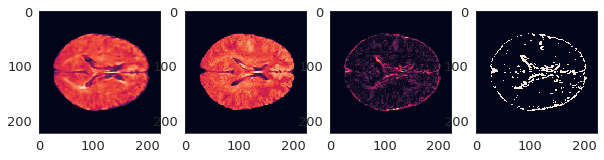

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(10, 10))
recon = np.concatenate(recons, 0).mean(axis=0).squeeze()
#recon = recons[0].squeeze()
ground = x.cpu().squeeze()

im1 = ax[0].imshow(recon)
im2 = ax[1].imshow(ground)
residual = np.abs(ground - recon)
im3 = ax[2].imshow(residual)
im4 = ax[3].imshow(residual > np.percentile(residual, 95))
print(residual.sum())

#plt.colorbar(im1, ax=ax[0])
#plt.colorbar(im2, ax=ax[1])
#plt.colorbar(im3, ax=ax[2])

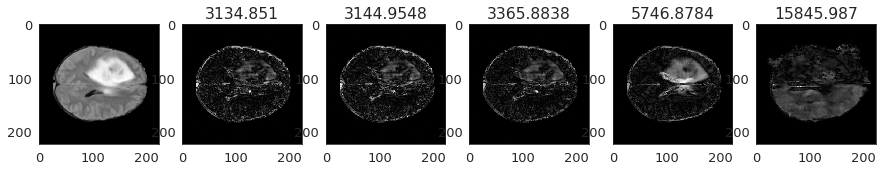

In [72]:
# Measuring the deltas across different stages
recons_by_stage = []
with torch.no_grad():
    for i in range(5):
        x_top = x[:, :, :224//2, :]
        x_bot = torch.flipud(x[:, :, 224//2:, :].squeeze().cpu()).unsqueeze(0).unsqueeze(0).to(device)
        
        ll_top, stage_top, _ = model(x_top, decode_from_p=(([True] * i) + ([False] * (4 - i))))
        ll_bot, stage_bot, _ = model(x_bot, decode_from_p=(([True] * i) + ([False] * (4 - i))))
        
        recons_by_stage.append(np.concatenate([ll_top.mean.permute(0, 2, 3, 1).cpu().numpy(), ll_bot.mean.permute(0, 2, 3, 1).cpu().numpy()[:, ::-1, :, :]], axis=1))
        
ground = x.cpu().squeeze()
fig, axes = plt.subplots(1, 6, figsize=(15, 15))
axes[0].imshow(ground, cmap='gray')
for rec, ax in zip(recons_by_stage, axes[1:]):
    rec = rec.squeeze()
    res = np.abs(ground - rec)
    ax.imshow(res, cmap='gray')
    ax.set_title(res.sum().numpy())

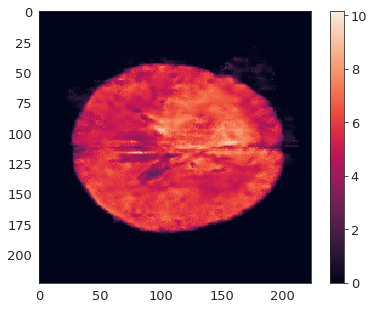

In [79]:
plt.imshow(np.sum(recons_by_stage, axis=0).squeeze())
plt.colorbar()

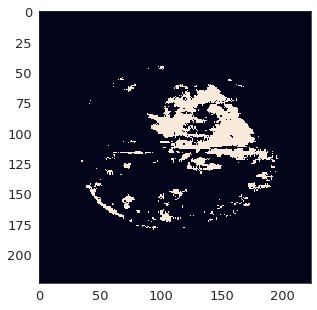

In [87]:
plt.imshow(np.sum(recons_by_stage, axis=0).squeeze() > 6.5)

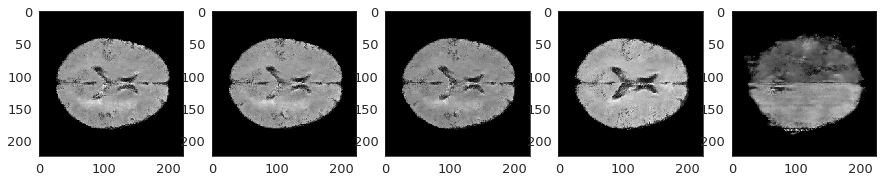

In [42]:
fig, axes = plt.subplots(1, 5, figsize=(15, 15))
for rec, ax in zip(recons_by_stage, axes):
    rec = rec.squeeze()
    ax.imshow(rec, cmap='gray')

0 [True, True, True, True]
1 [False, True, True, True]
2 [True, False, True, True]
3 [True, True, False, True]
4 [True, True, True, False]


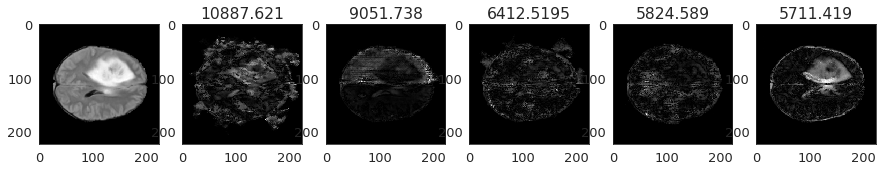

In [89]:
# Measuring the deltas across different stages, one latent at a time
recons_by_stage = []
with torch.no_grad():
    for i in range(5):
        x_top = x[:, :, :224//2, :]
        x_bot = torch.flipud(x[:, :, 224//2:, :].squeeze().cpu()).unsqueeze(0).unsqueeze(0).to(device)
        
        latent = [True] * 4
        
        # So the first recon is high fidelity
        if i > 0:
            latent[i - 1] = False
            
        print(i, latent)
            
        ll_top, stage_top, _ = model(x_top, decode_from_p=latent)
        ll_bot, stage_bot, _ = model(x_bot, decode_from_p=latent)
        
        recons_by_stage.append(np.concatenate([ll_top.mean.permute(0, 2, 3, 1).cpu().numpy(), ll_bot.mean.permute(0, 2, 3, 1).cpu().numpy()[:, ::-1, :, :]], axis=1))
        
ground = x.cpu().squeeze()
fig, axes = plt.subplots(1, 6, figsize=(15, 15))
axes[0].imshow(ground, cmap='gray')
for rec, ax in zip(recons_by_stage, axes[1:]):
    rec = rec.squeeze()
    res = np.abs(ground - rec)
    ax.imshow(res, cmap='gray')
    ax.set_title(res.sum().numpy())

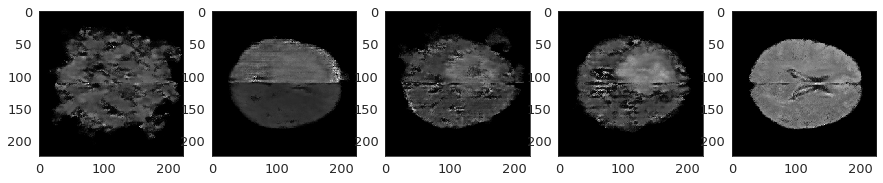

In [90]:
fig, axes = plt.subplots(1, 5, figsize=(15, 15))
for rec, ax in zip(recons_by_stage, axes):
    rec = rec.squeeze()
    ax.imshow(rec, cmap='gray')

### Hierarchical Segmentations

What's great about the HVAE is that we have a latent hierarchy, which allows us to produce reconstructions
of the images by emphasizing different latent variables at different layers. Maloe et al. provide the
L>k score, which in turn provides reconstructions of the images with latent layers atleast k deep in the
hierarchy (recons using the top k latent layers). This gives us more semantic reconstructions and ignores
low level features which would induce high fidelity reconstructions of anomalous regions in the brain,
however we lose great amounts of resolution because of this and as a result the residuals even on healthy 
examples have been observed to be quite noisy and grainy. This is evident when we see the residuals in the
ventricles which vary wildly between brains. The model has a high level understanding of what that region looks
like in the top latent layers, however it acts as a kind of average between all the variations and thus we 
see erroneously large residuals becuase of it in these regions due to subtle differences.

One way to mitigate this issue when looking at reconstructions in the highest latent layers is to model the
positional distributions of the residual values of the healthy brains, and threshold based on that (112x224
pixels = 25088 independent gaussian distributions for simplicity sake). Now the question is how do we 
incorporate information from the lower layers, since these have better reconstructions of the healthy parts.
* We can think of each reconstruction as a stack of matrices, such that for a single voxel, we have L other
  ones which gives us a 1xL vector for each voxel
* Then from there it is possible to interpret this as the feature space for each of the 25088/50176 pixels
* We don't expect each axis to be uniformly distributed, there should be a "change of basis" as we go up 
  through the dimensions as errors should be higher there
    * How do we account for this?
    * It's possible that we would simply weigh the higher layers more than the lower ones. Could we 
      automatically do this somehow? I.e fit a gaussian mixture to this data or something.
    * One thing to consider: the really good segmentation we are looking for may only rear its head when
      we look at the final few layers, so then the info from the lower layers won't catch it.
    * I think lower layer information should only be there to reduce the FPR.
* We can interpret larger vectors to be more OOD via something like the L2-norm (up for discussion)
* Thinking of the simple 2D case, x-axis is the residual from a good reconstruction (L>0) and the y is
  L>k. We expect that even for OOD in the ordered pairs (x, y), x should be quite small in magnitude and
  also similar across the two classes. It might not be worth taking it into account as it would essentially
  be a redundantv variable. There might be some way to make this hi-fi reconstruction useful however
     * One idea would be after deciding which voxels are actually anomalous, you reduce FPR by masking
     out the anomalous part, then using the hi-fi reconstruction on everything but the segmented part.
* Fit the gaussians so we know the distribution of the residuals at each layer of reconstruction.

In [5]:
dirname = '/data/BraTS2018/BraTS18_Training_norm/'
seg_dirname = '/data/BraTS2018/BraTS18_Training_norm/'
brats_2018_paths = sorted(get_nifti(dirname, key_words={'flair_Warped'}))
brats_2018_seg_paths = sorted(get_nifti(seg_dirname, key_words={'seg'}), key=lambda f: f.split('/')[-1])

random.seed(11)
path_pairs = list(zip(brats_2018_paths, brats_2018_seg_paths))
segs = [seg for _, seg in path_pairs]
imgs = [train for train, _ in path_pairs]

train_size = int(len(imgs) - np.ceil(0.1 * len(imgs)))

train_fn = imgs[:train_size]
seg_train_fn = segs[:train_size]
val_fn = imgs[train_size:]
seg_val_fn = segs[train_size:]
model = models['axial']

In [6]:
train_dset = np.load('/home/derek/mood_patches/brats_patches/brats_train_half_slices_reg_norm_no_scale.npz')['X_train']

(array([ 11.,  22., 181., 309.,  71.,   5.,   0.,   0.,   0.,   3.]),
 array([0.33069186, 0.53022934, 0.72976682, 0.9293043 , 1.12884178,
        1.32837926, 1.52791674, 1.72745422, 1.92699169, 2.12652917,
        2.32606665]),
 <a list of 10 Patch objects>)

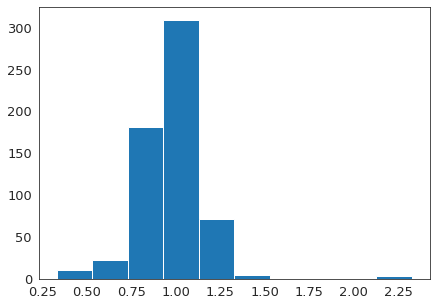

In [7]:
plt.hist(train_dset.reshape(602, -1)[:, 12000])

(array([  8.,  16.,  49., 182., 291.,  44.,   7.,   2.,   0.,   3.]),
 array([0.21197521, 0.39587568, 0.57977615, 0.76367662, 0.94757708,
        1.13147755, 1.31537802, 1.49927849, 1.68317896, 1.86707943,
        2.0509799 ]),
 <a list of 10 Patch objects>)

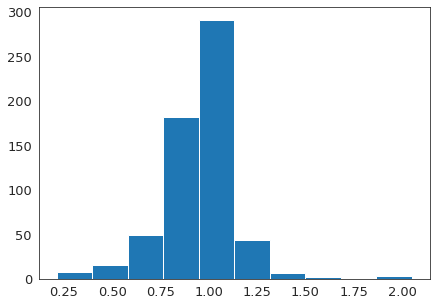

In [8]:
# Same as train_dset[:, 64, 112]
plt.hist(train_dset.reshape(602, -1)[:, 14448])

In [11]:
# Measuring the deltas for each training image, across stages
all_train_recons = []
with torch.no_grad():
    for i in range(5):
        stage = []
        for img in tqdm(range(train_dset.shape[0]), position=0):
            half_brain = torch.tensor(train_dset[[img]].astype('float32'), device=device).permute(0, 3, 1, 2)
            out = torch.full((1, 1, 112, 224), 0., dtype=torch.float32, device=device)
            
            for _ in range(10):
                ll, stage_top, _ = model(half_brain, decode_from_p=(([True] * i) + ([False] * (4 - i))))
                out += ll.mean
                
            out /= 10
            #ll, stage_top, _ = model(half_brain, decode_from_p=(([True] * i) + ([False] * (4 - i))))
            #out = ll.mean
            
            stage.append(out.permute(0, 2, 3, 1).cpu().numpy().squeeze())
        all_train_recons.append(stage)
        
# ground = x.cpu().squeeze()
# fig, axes = plt.subplots(1, 6, figsize=(15, 15))
# axes[0].imshow(ground, cmap='gray')
# for rec, ax in zip(recons_by_stage, axes[1:]):
#     rec = rec.squeeze()
#     res = np.abs(ground - rec)
#     ax.imshow(res, cmap='gray')
#     ax.set_title(res.sum().numpy())

100%|██████████| 602/602 [01:06<00:00,  9.00it/s]


In [12]:
residuals = []
for stage in all_train_recons:
    stage_residuals = []
    for ind, recon in enumerate(stage):
        stage_residuals.append(np.abs(train_dset[ind].squeeze() - recon).ravel())
    residuals.append(np.c_[stage_residuals])
    
residuals = np.c_[residuals]
residuals.shape

(5, 602, 25088)

(array([368., 135.,  40.,  28.,  15.,   8.,   5.,   2.,   0.,   1.]),
 array([0.00007626, 0.04548823, 0.0909002 , 0.13631217, 0.18172413,
        0.2271361 , 0.27254807, 0.31796004, 0.36337201, 0.40878398,
        0.45419594]),
 <a list of 10 Patch objects>)

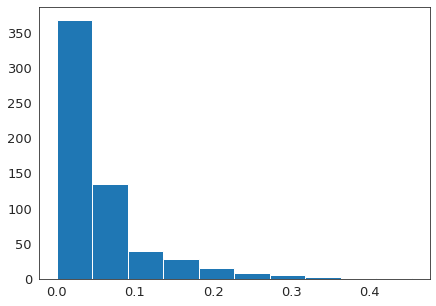

In [13]:
# As expected, the distribution of the L>0 reconstructions is quite faithful and has an
# exponential distribution
plt.hist(residuals[0, :, 12009])

(array([ 39., 126., 149., 152.,  83.,  39.,  10.,   2.,   1.,   1.]),
 array([0.00001896, 0.00023412, 0.00044929, 0.00066445, 0.00087962,
        0.00109478, 0.00130995, 0.00152511, 0.00174028, 0.00195544,
        0.00217061]),
 <a list of 10 Patch objects>)

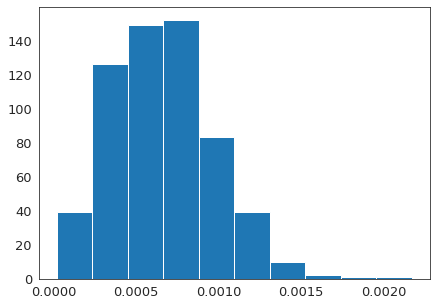

In [14]:
plt.hist(residuals[0, :, 0])

#### Quick note on Kurtosis
Kurtosis is the measure of a probability distribution's tailedness, that is it is a quantity that measures the
shape of the tails of the distribution. It is calculated by taking the fourth moment of the distribution
and standardizing it (usually by dividing by the variance squared).

https://gregorygundersen.com/blog/2020/04/11/moments/ --> good blog about moments of a probability distribution.

In [16]:
# Measuring the kurtosis of each distribution to check similarity
from scipy.stats import kurtosis
import scipy.stats as stats
#l_0_recon_kurt = kurtosis(residuals[0, :, 12006])

kurts_by_stage = np.c_[[kurtosis(stage, axis=0) for stage in residuals]]
print(kurts_by_stage.shape)
kurts_by_stage

(5, 25088)


array([[  0.80712947,   0.27522048,  -0.12192536, ...,   1.09298842,
         -0.24518919,   1.10571895],
       [  0.94709257,   0.46403042,   0.1874133 , ...,   0.40952916,
          0.94337604,   0.18346638],
       [584.56270888,   0.10877278,   0.52407427, ...,   0.23250268,
          0.39667894,   0.28603841],
       [  0.78460412,   0.61847029,   0.58182393, ...,   0.8925638 ,
          1.17531445,   0.73761909],
       [ -0.00207576,   0.36847878,  -0.01600337, ...,  69.80761863,
        258.97980088,  45.95947457]])

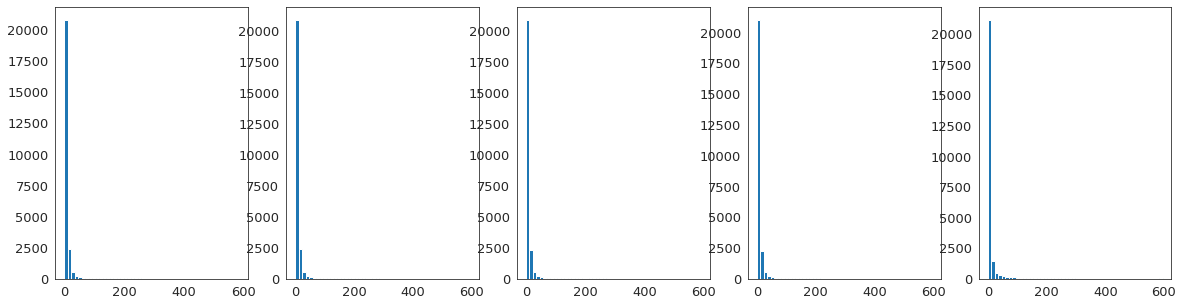

In [17]:
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for i, ax in enumerate(axes.ravel()):
    ax.hist(kurts_by_stage[i], bins=50)
    #ax.set_ylim(0, 500)

As we can see, the majority of residuals across the 602 half brains in the data set have a kurtosis very
close to 0, which means that a good portion of the data indeed has tails like a normal distribution. This
gives a intuitive justification for modelling the distribution of the pixel-wise residuals as in each pixel
as a gaussian. One key thing to notice however is that the distributions become less gaussian as we go up the
hierarchy.

Values near 0 = distributions with broader tails. High values mean distributions with very thin tails, that
quickly disappear. This is why we see values like 600, when they are highly concentrated around one value.

(array([600.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([0.        , 0.01916493, 0.03832987, 0.0574948 , 0.07665974,
        0.09582467, 0.11498961, 0.13415454, 0.15331948, 0.17248441,
        0.19164935]),
 <a list of 10 Patch objects>)

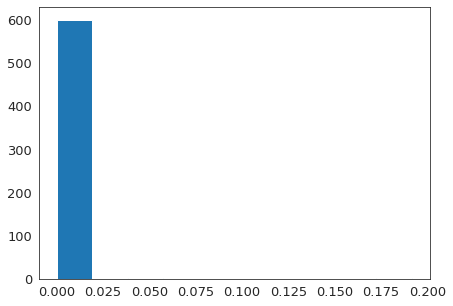

In [15]:
plt.hist(residuals[4, :, -1])

(array([181., 152.,  98.,  69.,  31.,  28.,  21.,  10.,   7.,   5.]),
 array([0.00124844, 0.16212541, 0.32300239, 0.48387936, 0.64475633,
        0.8056333 , 0.96651027, 1.12738725, 1.28826422, 1.44914119,
        1.61001816]),
 <a list of 10 Patch objects>)

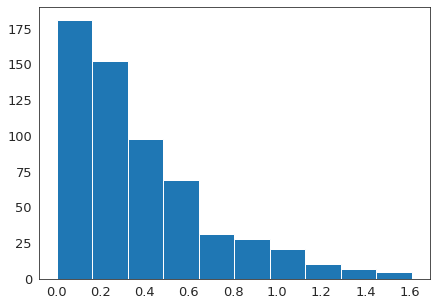

In [124]:
# As expected, the distribution of the L>0 reconstructions is quite faithful and has an
# exponential/half-normal distribution
plt.hist(residuals[4, :, 12001])

(array([434., 115.,  33.,  12.,   3.,   3.,   0.,   1.,   0.,   1.]),
 array([0.00002802, 0.084763  , 0.16949798, 0.25423296, 0.33896793,
        0.42370291, 0.50843789, 0.59317287, 0.67790785, 0.76264282,
        0.8473778 ]),
 <a list of 10 Patch objects>)

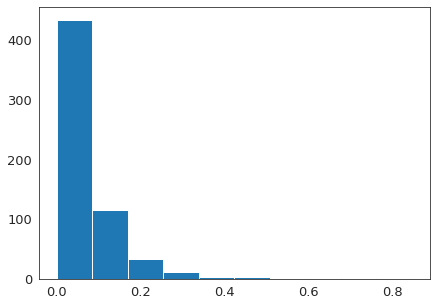

In [110]:
plt.hist(residuals[2, :, 12001])

(array([275., 160.,  72.,  44.,  23.,  10.,   7.,   9.,   1.,   1.]),
 array([0.00001643, 0.03790144, 0.07578646, 0.11367147, 0.15155649,
        0.1894415 , 0.22732652, 0.26521153, 0.30309655, 0.34098156,
        0.37886657]),
 <a list of 10 Patch objects>)

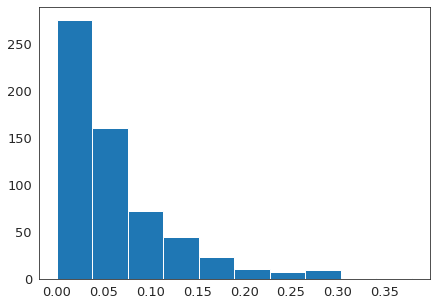

In [119]:
plt.hist(residuals[2, :, 11509])

### Fitting Half-Norm

In [16]:
loc, scale = stats.halfnorm.fit(residuals[2, :, 11509])
loc, scale

(8.093596974203645e-05, 0.10719934610605157)

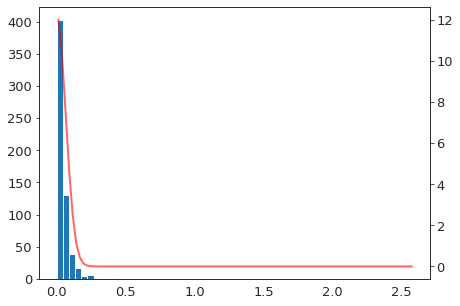

In [18]:
halfnorm = stats.halfnorm()
loc, scale = stats.halfnorm.fit(residuals[2, :, 11509])

x = np.linspace(stats.halfnorm.ppf(0.01), stats.halfnorm.ppf(0.99), 100)

plt.hist(residuals[2, :, 11509])
plt.twinx()
plt.plot(x, stats.halfnorm.pdf(x, loc=loc, scale=scale), 'r-', lw=2, alpha=0.6, label='halfnorm pdf')

In [148]:
stats.halfnorm.pdf(0.001, loc=loc, scale=scale)

9.257605996815775

In [153]:
1 - stats.halfnorm.cdf(0.01, loc=loc, scale=scale)

0.9077762451244984

### Using These Fitted Distributions for Pixel-wise OOD Detections

In [19]:
# Computing the loc and scale for each of the half norm distributions fitted 
# to each of the pixel distributions
dist_params = [stats.halfnorm.fit(residuals[3, :, i]) for i in range(residuals.shape[-1])]

In [20]:
anom_dset = np.load('/home/derek/mood_patches/brats_patches/brats_anom_half_slices_reg_norm_no_scale.npz')['X_toy']

In [21]:
anom_dset.shape

(1047, 112, 224, 1)

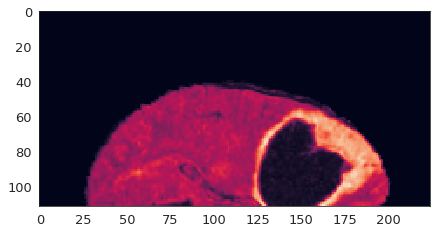

In [22]:
plt.imshow(anom_dset[4].squeeze())

In [24]:
# Measuring the deltas for each anomalous validation image, across stages
all_anom_recons = []
with torch.no_grad():
    for i in range(5):
        stage = []
        for img in tqdm(range(anom_dset.shape[0]), position=0):
            half_brain = torch.tensor(anom_dset[[img]].astype('float32'), device=device).permute(0, 3, 1, 2)
            out = torch.full((1, 1, 112, 224), 0., dtype=torch.float32, device=device)
            
            for _ in range(10):
                ll, stage_top, _ = model(half_brain, decode_from_p=(([True] * i) + ([False] * (4 - i))))
                out += ll.mean
                
            out /= 10
            stage.append(out.permute(0, 2, 3, 1).cpu().numpy().squeeze())
        all_anom_recons.append(stage)
        

anom_residuals = []
for stage in all_anom_recons:
    stage_residuals = []
    for ind, recon in enumerate(stage):
        stage_residuals.append(np.abs(anom_dset[ind].squeeze() - recon).ravel())
    anom_residuals.append(np.c_[stage_residuals])
    
anom_residuals = np.c_[anom_residuals]
anom_residuals.shape
        
# ground = x.cpu().squeeze()
# fig, axes = plt.subplots(1, 6, figsize=(15, 15))
# axes[0].imshow(ground, cmap='gray')
# for rec, ax in zip(recons_by_stage, axes[1:]):
#     rec = rec.squeeze()
#     res = np.abs(ground - rec)
#     ax.imshow(res, cmap='gray')
#     ax.set_title(res.sum().numpy())

100%|██████████| 1047/1047 [01:57<00:00,  8.91it/s]


(5, 1047, 25088)

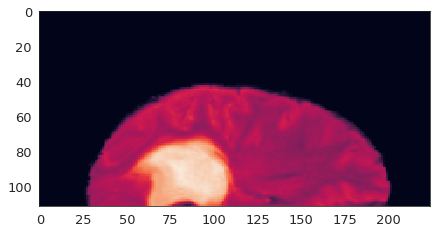

In [50]:
plt.imshow(anom_dset[66].squeeze())

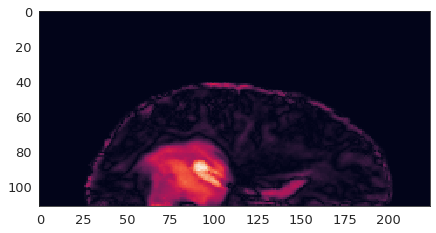

In [26]:
plt.imshow(anom_residuals[3, 66, :].reshape(112, 224))

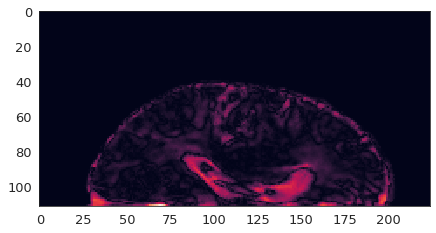

In [35]:
plt.imshow(anom_residuals[3, 67, :].reshape(112, 224))

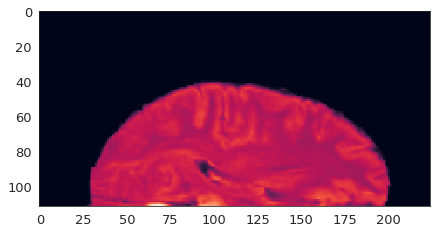

In [38]:
plt.imshow(anom_dset[67, :, :].squeeze())

In [39]:
probs = [1 - stats.halfnorm.cdf(pix_res, loc=loc, scale=scale) for (loc, scale), pix_res in zip(dist_params, anom_residuals[3, 67, :])]

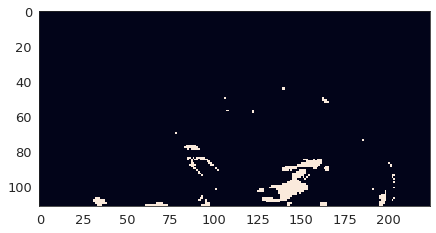

In [40]:
plt.imshow(np.array(probs).reshape(112, 224) < 0.0000001)

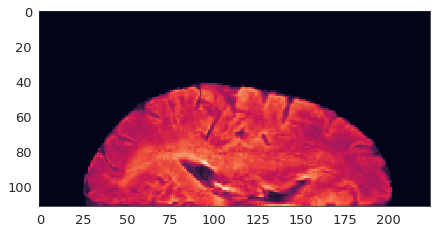

In [46]:
# Healthy residuals
plt.imshow(train_dset[71, :, :].squeeze())

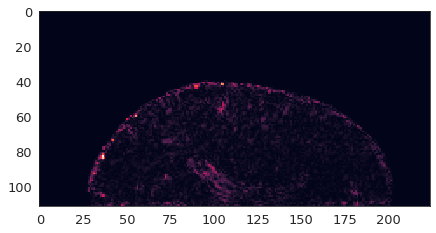

In [54]:
plt.imshow(residuals[3, 76, :].reshape(112, 224))

In [55]:
# Healthy val images
val_dset = np.load('/home/derek/mood_patches/brats_patches/brats_train_half_slices_reg_norm_no_scale.npz')['X_val']

In [265]:
# Measuring the deltas for each healthy validation image, across stages
# I consistently see issues with the ventricles in the valalous images,
# is this something we only see in non-training images?
all_val_recons = []
tune_val_res = []
with torch.no_grad():
    for i in range(5):
        stage = []
        tune_stage = []
        for img in tqdm(range(val_dset.shape[0]), position=0):
            half_brain = torch.tensor(val_dset[[img]].astype('float32'), device=device).permute(0, 3, 1, 2)
            out = torch.full((1, 1, 112, 224), 0., dtype=torch.float32, device=device)
            
            for _ in range(10):
                ll, stage_top, _ = model(half_brain, decode_from_p=(([True] * i) + ([False] * (4 - i))))
                out += ll.mean
                tune_stage.append(np.abs((half_brain.squeeze() - ll.mean.permute(0, 2, 3, 1).squeeze()).cpu().numpy()))
                
            out /= 10
            stage.append(out.permute(0, 2, 3, 1).cpu().numpy().squeeze())
        all_val_recons.append(stage)
        tune_val_res.append(tune_stage)
        

val_residuals = []
for stage in all_val_recons:
    stage_residuals = []
    for ind, recon in enumerate(stage):
        stage_residuals.append(np.abs(val_dset[ind].squeeze() - recon).ravel())
    val_residuals.append(np.c_[stage_residuals])
    
val_residuals = np.c_[val_residuals]
tune_val_res = np.c_[tune_val_res]
val_residuals.shape

100%|██████████| 61/61 [00:06<00:00,  8.96it/s]


(5, 61, 25088)

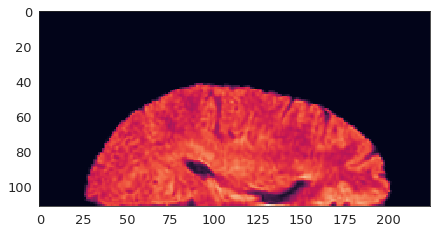

In [57]:
plt.imshow(val_dset[0].squeeze())

Below we can see that the healthy validation images also see erroneously high residuals near
the ventricles. It is important that we correct for this by including these images when computing
our healthy pixel distributions

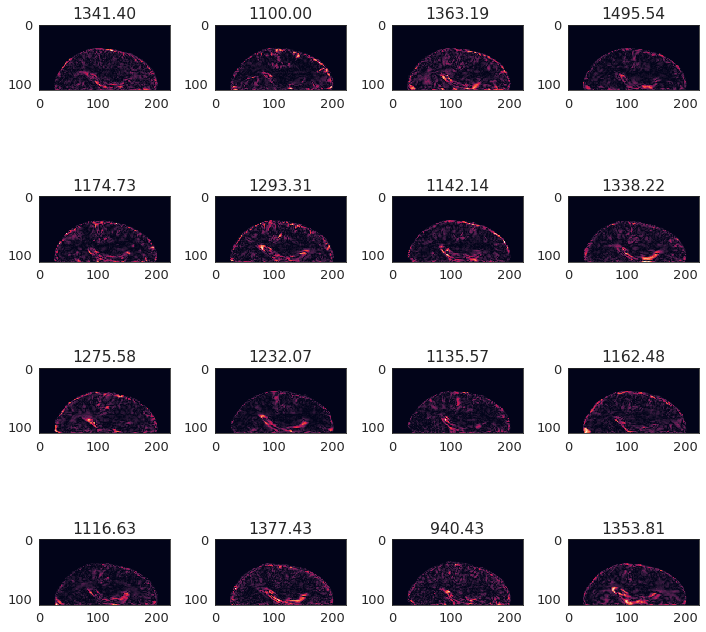

In [74]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for ind, ax in enumerate(axes.ravel()):
    r = val_residuals[3, ind * 3].reshape(112, 224)
    ax.imshow(r)
    ax.set_title(f'{r.sum():.2f}')
fig.tight_layout()

We won't be able to see this phenomenon in the training images as the model has likely overfit on these
examples and expects the ventricles to be in a certain way

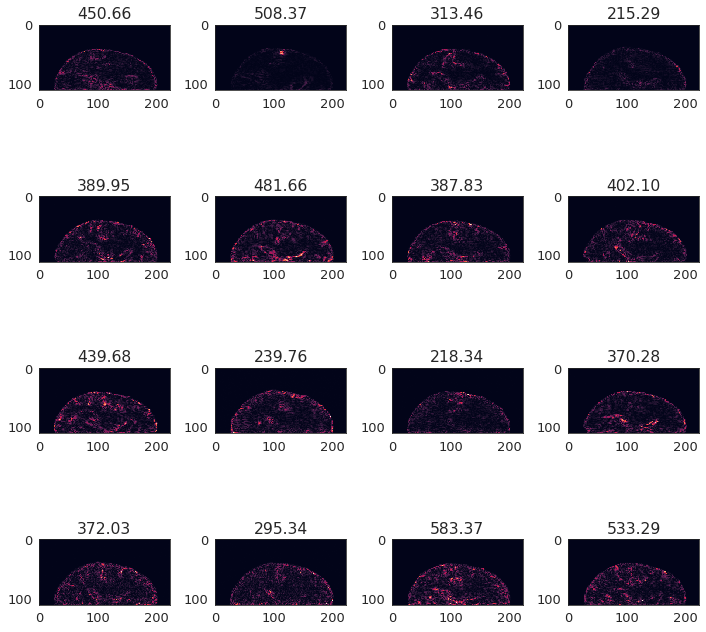

In [75]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for ind, ax in enumerate(axes.ravel()):
    r = residuals[3, ind * 3].reshape(112, 224)
    ax.imshow(r)
    ax.set_title(f'{r.sum():.2f}')
fig.tight_layout()

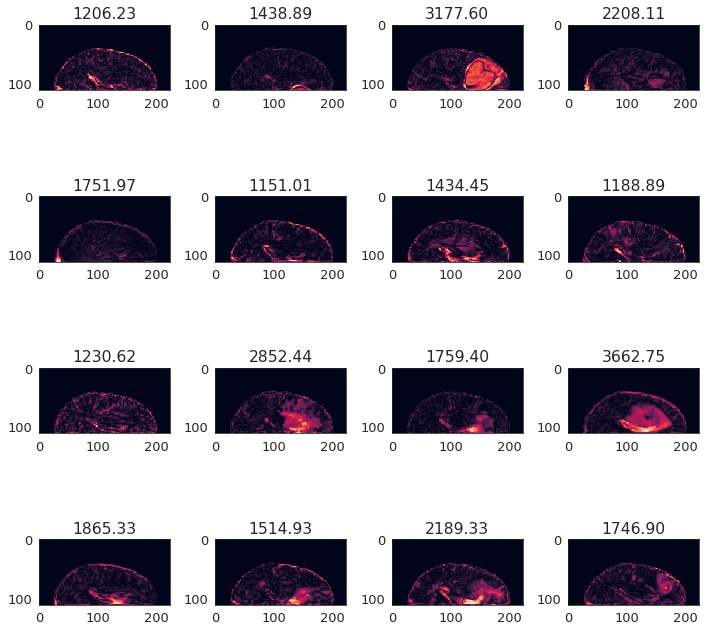

In [79]:
# Anomalous images for posterity
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for ind, ax in enumerate(axes.ravel()):
    r = anom_residuals[3, ind * 3].reshape(112, 224)
    ax.imshow(r)
    ax.set_title(f'{r.sum():.2f}')
fig.tight_layout()

Knowing that the distribution will be heavily tuned towards the training images, we will need to account for
this shift by fitting our distribution parameters on the validation images instead/aswell

In [367]:
# Fitting half norm on the validation residuals
val_to_fit = tune_val_res.reshape(5, 610, -1)
dist_params = [stats.halfnorm.fit(val_to_fit[3, :, i]) for i in range(residuals.shape[-1])]

In [329]:
pix = tune_val_res[1:4, :, 0, 0]
stats.halfnorm.fit(pix)

(-7.822430752336379e-12, 0.0011392672180133487)

In [330]:
stats.halfnorm.fit(tune_val_res[3, :, 0, 0])

(-4.4385516160446166e-11, 0.0012142679122617924)

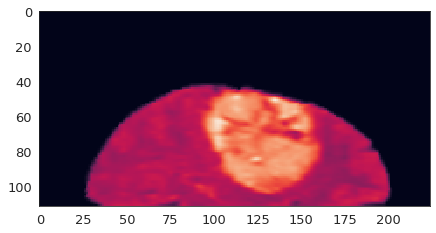

In [435]:
plt.imshow(anom_dset[158].squeeze())

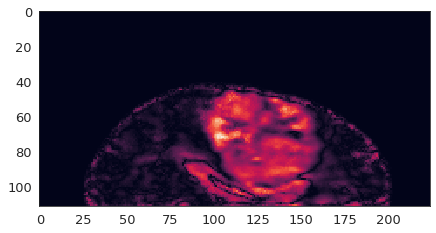

In [434]:
plt.imshow(anom_residuals[3, 158, :].reshape(112, 224))

In [430]:
probs = [1 - stats.halfnorm.cdf(pix_res, loc=loc, scale=scale) for (loc, scale), pix_res in zip(dist_params, anom_residuals[3, 155, :])]

Very weird reconstruction at index 80-90, bad warping?

Make the alpha level lower for better segmentation

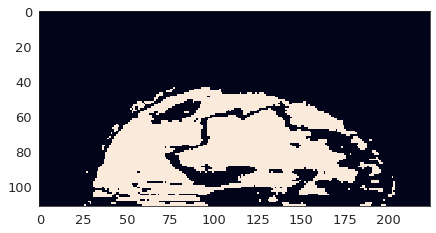

In [431]:
plt.imshow((np.array(probs).reshape(112, 224) < 0.005) * (anom_dset[155] != 0).squeeze())

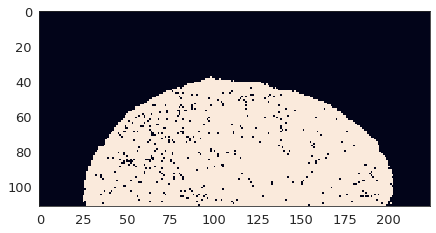

In [345]:
plt.imshow(np.array(probs[1]).reshape(112, 224) < 0.000001)

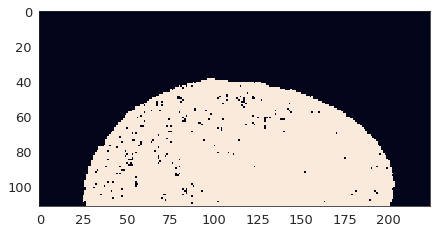

In [346]:
plt.imshow(np.array(probs[2]).reshape(112, 224) < 0.0001)

### Side Note: Comparing Distribution of Known Benign Pixels in OOD vs. Healthy

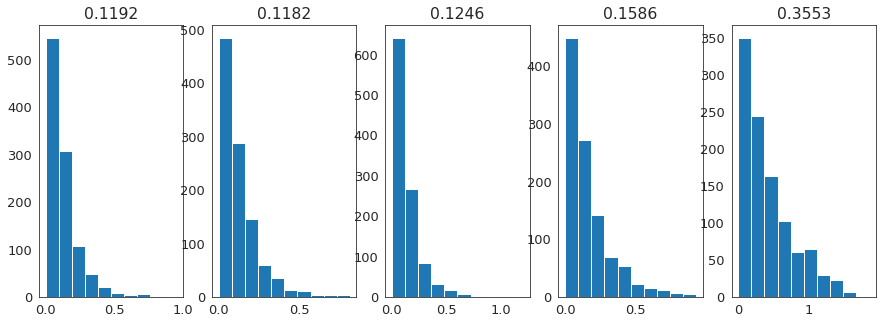

In [47]:
pix = 11550
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for ind, ax in enumerate(axes):
    ax.hist(anom_residuals[ind, :, pix])
    ax.set_title(f'{anom_residuals[ind, :, pix].std():.4}')

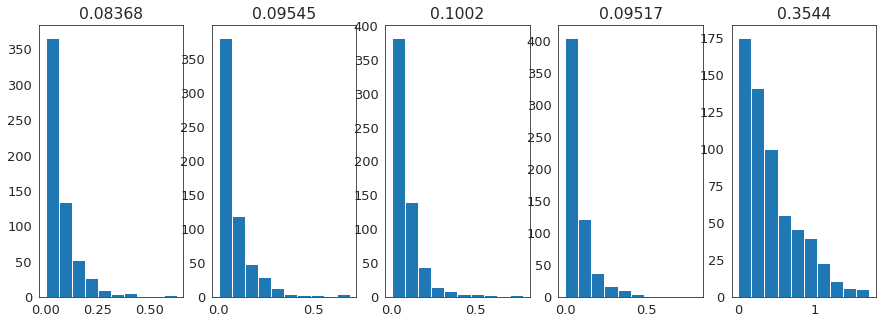

In [48]:
pix = 11550
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for ind, ax in enumerate(axes):
    ax.hist(residuals[ind, :, pix])
    ax.set_title(f'{residuals[ind, :, pix].std():.4}')

0.0009410276123074649

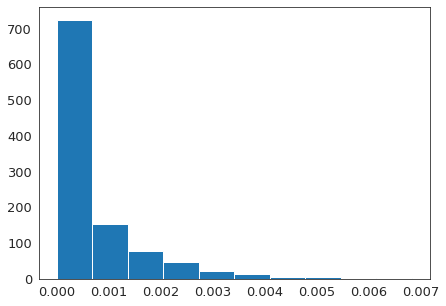

In [28]:
plt.hist(anom_residuals[1, :, 0])
anom_residuals[1, :, 0].std()

### PCA

In [69]:
from sklearn.decomposition import PCA
anom_residuals[:, :, 0]

array([[0.        , 0.00195129, 0.        , ..., 0.        , 0.00201823,
        0.00063247],
       [0.0005777 , 0.        , 0.00282395, ..., 0.        , 0.00002761,
        0.        ],
       [0.00041345, 0.00056812, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00261098, 0.        , 0.00242004, ..., 0.        , 0.00168172,
        0.00204782],
       [0.00144642, 0.        , 0.00123145, ..., 0.        , 0.        ,
        0.00181416]])

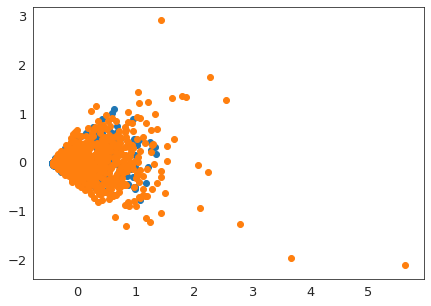

In [124]:
pix = 14460
pca = PCA(n_components=2)
pca.fit(np.vstack([residuals[1:, :, pix].reshape(-1, 4), anom_residuals[1:, :, pix].reshape(-1, 4)]))
proj = pca.transform(residuals[1:, :, pix].reshape(-1, 4))
proj2 = pca.transform(anom_residuals[1:, :, pix].reshape(-1, 4))
plt.scatter(proj[:, 0], proj[:, 1])
plt.scatter(proj2[:, 0], proj2[:, 1])

### Local Outlier Factor

In [157]:
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors=2, novelty=True).fit(residuals[[3], :, 0].reshape(-1, 1))
(lof.predict(anom_residuals[[3], :, 0].reshape(-1, 1)) == -1).sum()

116

### GMM
- An unsupervised learning model that operates under the assumption that the data was generated from n finite
  gaussian mixtures, and we attempt to learn the parameters to each of components (features of the data)
https://scikit-learn.org/stable/modules/mixture.html --> scikit learn page on GMMs
https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html#sphx-glr-auto-examples-mixture-plot-gmm-covariances-py --> better generalization if you change the covariance matrix structures.
- Fitting all the 112*224 gaussian mixtures costed 218 GB of memory

In [172]:
gm = GaussianMixture().fit(residuals[:, :, 0].reshape(-1, 5))

In [161]:
# Gaussian Mixture passes the sanity check
from sklearn.mixture import GaussianMixture
gm = GaussianMixture().fit(residuals[:, :, 0].reshape(-1, 5))
gm.predict(anom_residuals[:, :, 0].reshape(-1, 5)).sum()

0

In [176]:
gaussian_mixtures = [GaussianMixture().fit(residuals[:, :, i].reshape(-1, 5)) for i in range(residuals.shape[-1])]

In [167]:
import joblib

joblib.dump(gaussian_mixtures[0], 'gmm.joblib')

['gmm.joblib']

In [193]:
gmm_labels = [gmm.predict_proba(anom_residuals[:, 66, [pix_ind]].reshape(-1, 5)) for gmm, pix_ind in zip(gaussian_mixtures, range(anom_residuals.shape[-1]))]

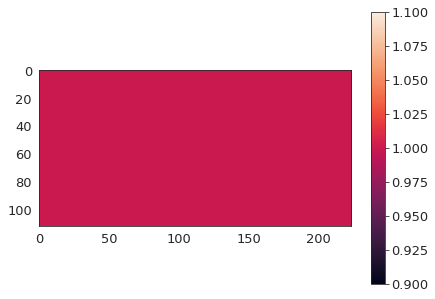

In [196]:
plt.imshow(np.concatenate(gmm_labels).reshape(112, 224))
plt.colorbar()

### One-class SVM
https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html

https://stackoverflow.com/questions/31681373/making-svm-run-faster-in-python

In [317]:
from sklearn.svm import OneClassSVM
#thresh_residuals = np.concatenate([residuals, val_residuals], axis=1)
#thresh_residuals = val_residuals
thresh_residuals = tune_val_res.reshape(5, 610, -1)
svm = OneClassSVM(kernel='rbf', nu=0.5, gamma=0.0005).fit(thresh_residuals[1:4, :, 0].reshape(-1, 3))
(svm.predict(anom_residuals[1:4, :, 0].reshape(-1, 3)) == -1).sum()

0

In [303]:
val_residuals[3, 0, :]

array([0.00038382, 0.00086199, 0.00015649, ..., 0.00086792, 0.00068968,
       0.00015033])

In [318]:
svms = [OneClassSVM(kernel='rbf', nu=0.5, gamma=0.0005).fit(thresh_residuals[1:4, :, i].reshape(-1, 3)) for i in range(residuals.shape[-1])]

In [319]:
svm_labels = [svm.predict(anom_residuals[1:4, 66, [pix_ind]].reshape(-1, 3)) for svm, pix_ind in zip(svms, range(anom_residuals.shape[-1]))]

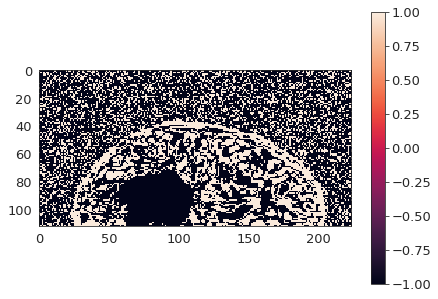

In [320]:
plt.imshow(np.concatenate(svm_labels).reshape(112, 224))
plt.colorbar()

In [ ]:
12 * 12

In [182]:
anom_residuals.shape

(5, 1047, 25088)

### Does More Reconstruction Samples = Better Anomaly Estimates

In [127]:
mc_samp_recons = []

with torch.no_grad():
    samp_img = torch.tensor(train_dset[[0]].astype('float32'), device=device).permute(0, 3, 1, 2)
    for _ in range(50):
        ll, stage, _ = model(samp_img)
        mc_samp_recons.append(ll.mean.permute(0, 2, 3, 1).cpu().numpy().squeeze())
mc_samp_recons = np.c_[mc_samp_recons]

(array([120.,  25.,  22.,  14.,   7.,   4.,   3.,   3.,   0.,   2.]),
 array([0.        , 0.00050107, 0.00100214, 0.0015032 , 0.00200427,
        0.00250534, 0.00300641, 0.00350748, 0.00400855, 0.00450961,
        0.00501068], dtype=float32),
 <a list of 10 Patch objects>)

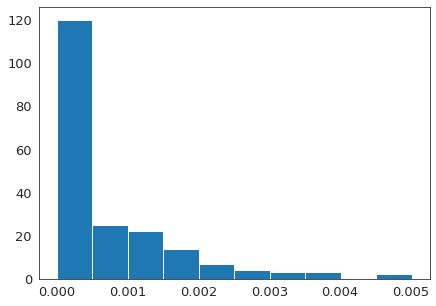

In [107]:
plt.hist(mc_samp_recons[:, 0, 0])

0.035630397


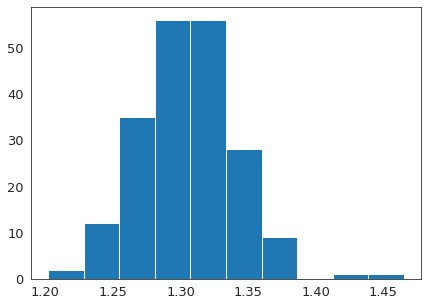

In [109]:
# The intensities of each pixel is actually normally distributed, we fail to capture this
# with our current approch. therefore
plt.hist(mc_samp_recons[:, 64, 112])
print(mc_samp_recons[:, 64, 112].std())

In [128]:
mc_samp_recons.mean(0)[64, 112]

1.3013165

In [ ]:
# Measuring the deltas for each training image, with a single stage
single_train_recons = []
num_samp = 10
with torch.no_grad():
    for img in tqdm(range(train_dset.shape[0]), leave=True, position=0):
        half_brain = torch.tensor(train_dset[[img]].astype('float32'), device=device).permute(0, 3, 1, 2)
        out = torch.full((1, 1, 112, 224), 0., dtype=torch.float32, device=device)

        for _ in range(num_samp):
            ll, stage_top, _ = model(half_brain, decode_from_p=[True, True, False, False])
            out += ll.mean

        out /= num_samp
        #ll, stage_top, _ = model(half_brain, decode_from_p=(([True] * i) + ([False] * (4 - i))))
        #out = ll.mean
        single_train_recons.append(stage)

 10%|█         | 61/602 [00:06<01:01,  8.78it/s]

In [ ]:
single_stage_residuals = []
for stage in single_train_recons:
    stage_residuals = []
    for ind, recon in enumerate(stage):
        stage_residuals.append(np.abs(train_dset[ind].squeeze() - recon).ravel())
    single_stage_residuals.append(np.c_[stage_residuals])
    
single_stage_residuals = np.c_[singe_stage_residuals]
singe_stage_residuals.shape